In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
import seaborn as sns
from scipy.stats import median_abs_deviation
import math

#pd.options.display.float_format = '{:.2f}'.format

from model_SARIMA import *
from model_naiv import *
from test_mean import *
from test_correlation import *
from cross_validation import *

warnings.filterwarnings("ignore")

/Users/alex/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Datensatz lesen

In [2]:
df = pd.read_csv('Walmart_Sales.csv', parse_dates=['Date'], dayfirst=True)
df.columns = df.columns.str.lower()

actual_values_dict = {}

for store in range(1, 46):
    store_df = df[df['store'] == store].copy()
    store_df.sort_values('date', inplace=True)
    store_df.set_index('date', inplace=True)

    actual_values_dict[store] = store_df['weekly_sales']

Modell wählen

In [3]:
model_type = 'SARIMA'
#model_type = 'Naive'

Alle Residuen und Fitted Values berechnen

In [4]:
fitted_values_dict = {}
residuals_dict = {}
forecast_dict = {}

if model_type == 'Naive':
    residuals_dict, fitted_values_dict = naive_for_all_stores('Walmart_Sales.csv')

if model_type == 'SARIMA':
    sarima_models, y_train_dict, y_test_dict = SARIMA_for_all_stores('Walmart_Sales.csv', whichorder = 75)


Store 1: Modell erstellt mit Order (2, 0, 1) und Seasonal Order (1, 0, 0, 52)
Store 2: Modell erstellt mit Order (2, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 3: Modell erstellt mit Order (5, 0, 0) und Seasonal Order (0, 0, 2, 52)
Store 4: Modell erstellt mit Order (0, 1, 2) und Seasonal Order (0, 1, 0, 52)
Store 5: Modell erstellt mit Order (2, 0, 1) und Seasonal Order (1, 0, 0, 52)
Store 6: Modell erstellt mit Order (1, 0, 5) und Seasonal Order (1, 0, 0, 52)
Store 7: Modell erstellt mit Order (0, 0, 1) und Seasonal Order (0, 1, 0, 52)
Store 8: Modell erstellt mit Order (2, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 9: Modell erstellt mit Order (0, 1, 1) und Seasonal Order (1, 0, 0, 52)
Store 10: Modell erstellt mit Order (2, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 11: Modell erstellt mit Order (2, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 12: Modell erstellt mit Order (2, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 13: Modell erstellt mit Order (2, 0, 2) und Seasonal Or

In [5]:
errors_dict = {}

if model_type == 'SARIMA':
    for store in range(1, 46):
        model = sarima_models.get(store)

        # in-sample
        fitted_values_dict[store] = model.fittedvalues.iloc[1:]
        residuals_dict[store] = model.resid.iloc[1:]

        # out-of-sample
        forecast_dict[store] = model.get_forecast(steps=43)
        forecast_dict[store] = forecast_dict[store].predicted_mean

        errors_dict[store] = forecast_dict[store] - y_test_dict[store]



print(len(forecast_dict[1]))
#print(len(y_test_dict[1]))
#print(len(errors_dict[1]))
print(len(residuals_dict[1]))



43
99


Residuen

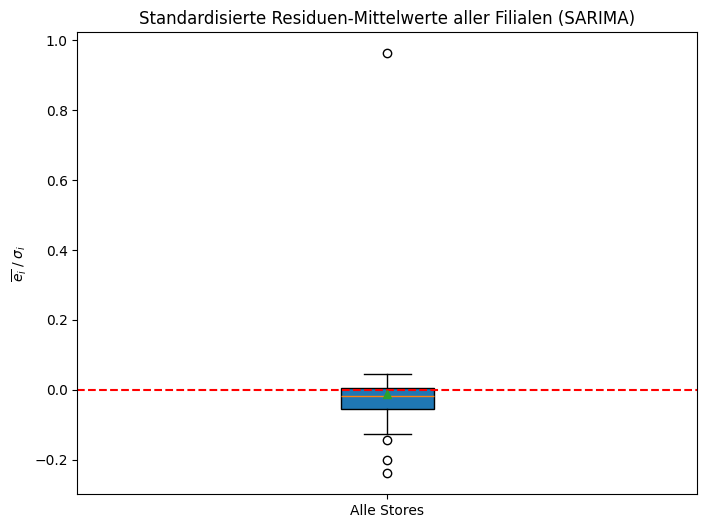

[0.019889957648118458, -0.04001185654042026, -0.014207082411458924, -0.054356275185534986, 0.031404926675711584, -0.025839461176072054, 0.9624564443047212, 0.008249858464773014, -0.14404828408320122, -0.03029061608806037, 0.012413232513947886, 0.00448527462684979, 0.03132769153815736, -0.06906516870729022, -0.02316319811106381, 0.025399656585268774, -0.1277042481446823, -0.061470419147431475, -0.02740506540410288, -0.007736856089048716, -0.005619053066818966, -0.003409952765290262, 0.004209045157593717, -0.018464293776967632, -0.009894363661544205, 0.007620158892380157, -0.037740656164087796, -0.016260739442977155, -0.012926561504389726, -0.024672211744960933, -0.10162535954790637, 0.0456360077844797, -0.01780306988445812, 0.017129942469123832, 0.020173013722455748, -0.017357341225885115, -0.10169767308905166, -0.07612602430456777, -0.20150133367502043, 0.0037944730866240396, -0.2386490661562798, -0.06988892317393215, -0.11092745199204807, -0.018477820501508622, -0.00812379117848703]
M

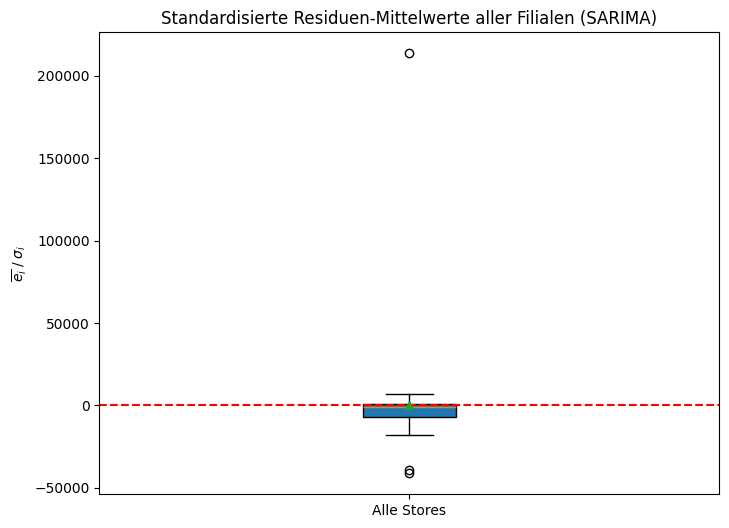

In [6]:
# Standadisierte Mittelwerte
resid_bias = [] 
for store in sorted(residuals_dict.keys(), key=int):
    resid = residuals_dict[store]
    mean = resid.mean()
    std = resid.std(ddof=0)        # Populations-Std (ddof=0)
    if std == 0:
        resid_bias.append(np.nan)
    else:
        resid_bias.append(mean / std) # standardisierter Bias

# Erstelle den Boxplot der Mittelwerte
plt.figure(figsize=(8, 6))
plt.boxplot(resid_bias, patch_artist=True, showmeans=True)
plt.title('Standardisierte Residuen-Mittelwerte aller Filialen ({})'.format(model_type))
plt.ylabel(r'$\overline{e_i}\; / \;\sigma_i$')
plt.xticks([1], ["Alle Stores"])
plt.axhline(0, color ='red', ls='--')
plt.show()


print(resid_bias)
print("Mittelwert: ", np.mean(resid_bias))
print("Median: ", np.median(resid_bias))



# Normale Mittelwerte
resid_means = [] 
for store in sorted(residuals_dict.keys(), key=int):
    resid_mean = residuals_dict[store].mean()

    resid_means.append(resid_mean)

plt.figure(figsize=(8, 6))
plt.boxplot(resid_means, patch_artist=True, showmeans=True)
plt.title('Standardisierte Residuen-Mittelwerte aller Filialen ({})'.format(model_type))
plt.ylabel(r'$\overline{e_i}\; / \;\sigma_i$')
plt.xticks([1], ["Alle Stores"])
plt.axhline(0, color ='red', ls='--')
plt.show()


Korrelations Tests

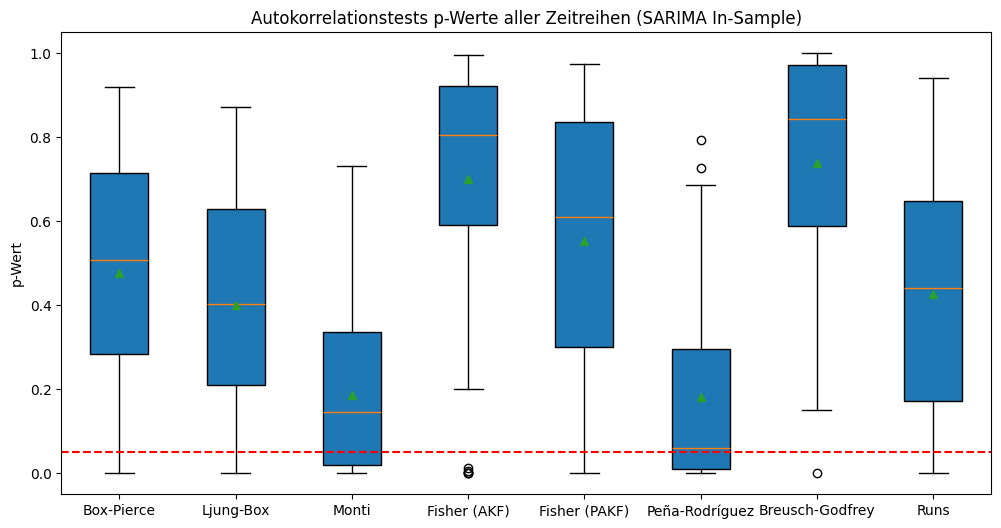

BOX-PIERCE Mittelwert: 0.4748479406570567 Median: 0.5063421687498042 Standardabweichung: 0.2750579018593013 Annahme (%): 88.88888888888889
LJUNG-BOX Mittelwert: 0.3996181886645963 Median: 0.4023591141518794 Standardabweichung: 0.255558956822994 Annahme (%): 86.66666666666667
MONTI Mittelwert: 0.18513931539424308 Median: 0.14392627408352332 Standardabweichung: 0.19085283983306844 Annahme (%): 64.44444444444444
FISHER (AKF) Mittelwert: 0.6982943374109557 Median: 0.804524723930342 Standardabweichung: 0.30715430641277447 Annahme (%): 88.88888888888889
FISHER (PAKF) Mittelwert: 0.5529530894255432 Median: 0.6078519719232183 Standardabweichung: 0.3226070435196003 Annahme (%): 88.88888888888889
PEÑA-RODRIGUEZ Mittelwert: 0.18025057211291676 Median: 0.05992875005616949 Standardabweichung: 0.22939246661645743 Annahme (%): 53.333333333333336
BREUSCH-GODFREY Mittelwert: 0.7383684634011957 Median: 0.841728212591079 Standardabweichung: 0.27455807243082775 Annahme (%): 97.77777777777777
RUNS Mittelwe

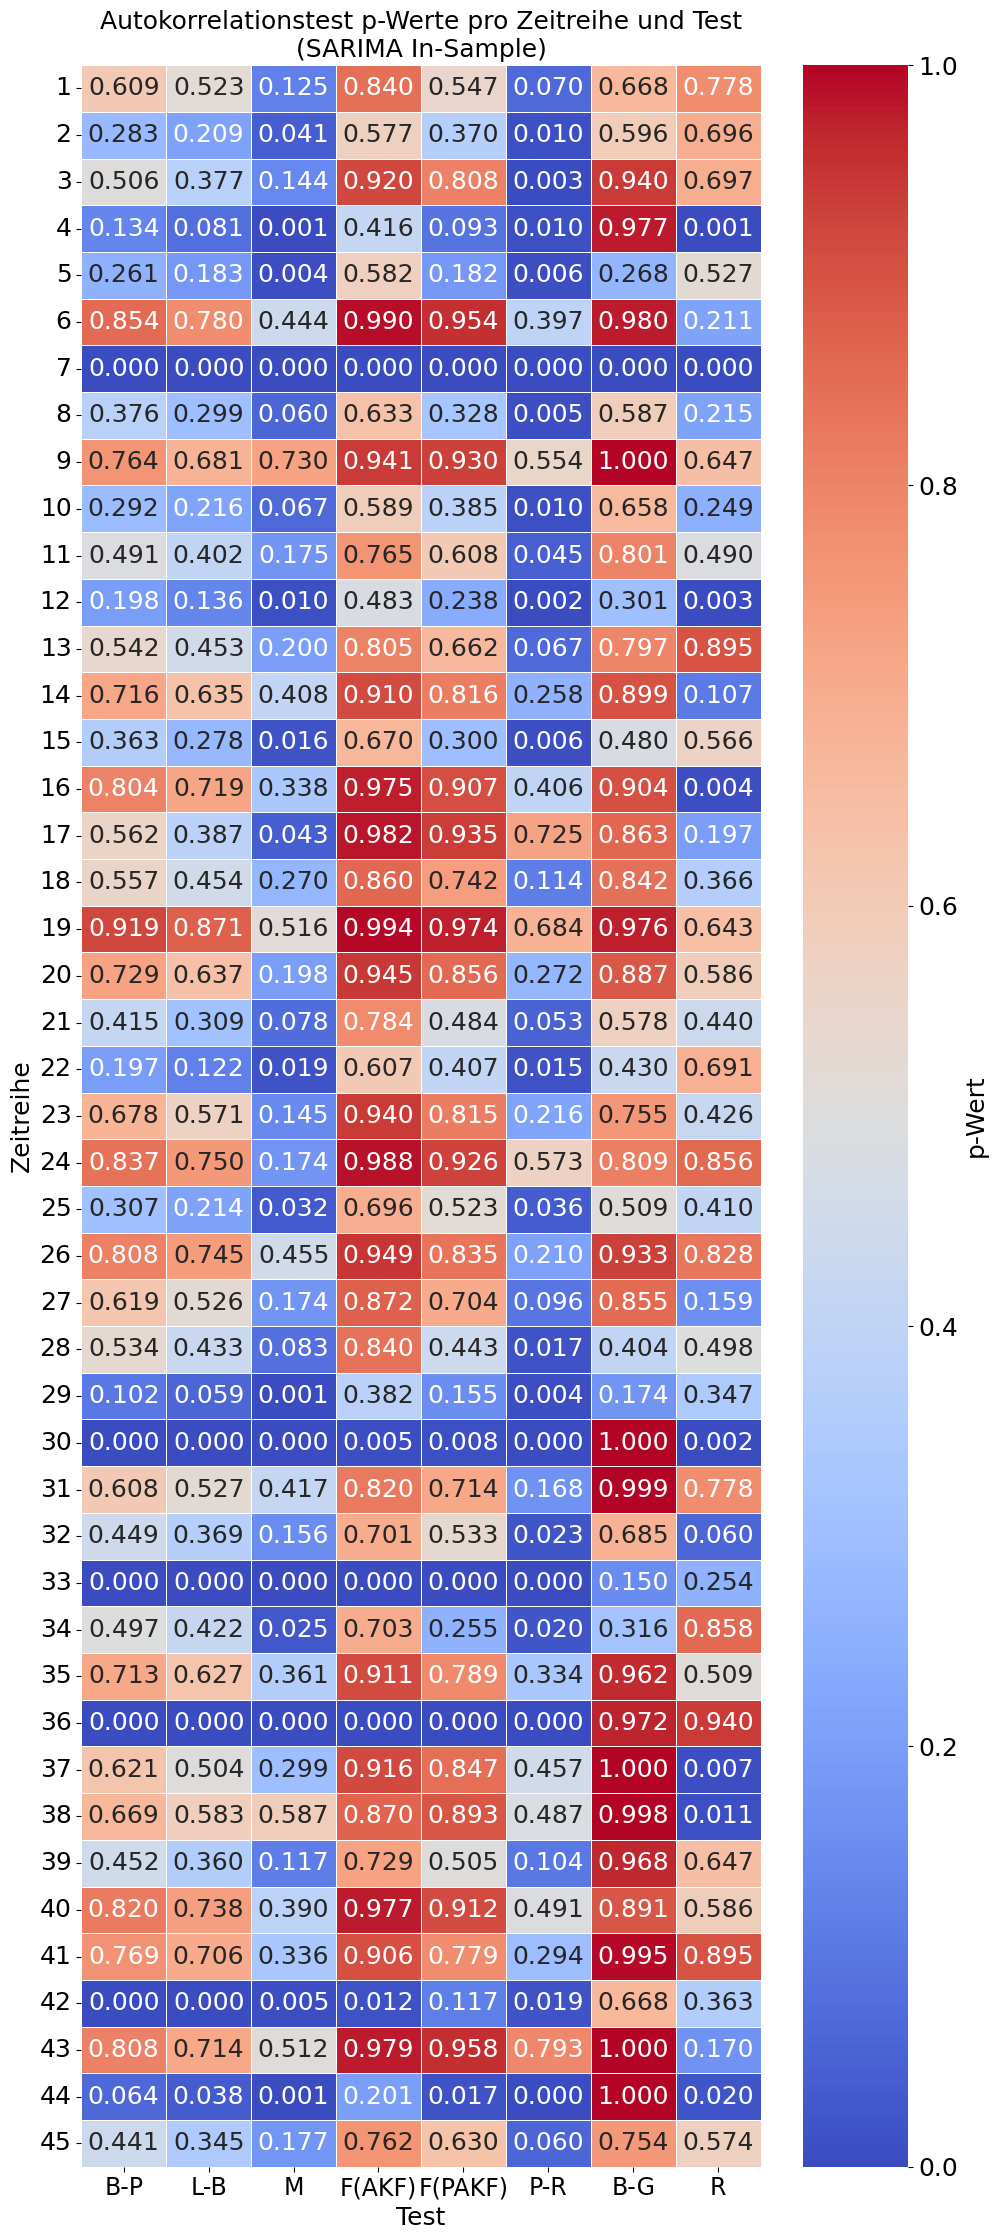

In [7]:
bp_pvalues = []
lb_pvalues = []
bg_pvalues = []
rt_pvalues = []
m_pvalues = []
f_pvalues = []
f2_pvalues = []
pr_pvalues = []
pr2_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    resid = residuals_dict.get(store) #Residuen für den Store

    sales = df[df['store'] == store].copy() #Zeitreihe für den Store
    sales.set_index('date', inplace=True)
    sales = sales['weekly_sales']
    sales = sales.asfreq('W-FRI')

    if resid is not None:
        # Box-Pierce Test
        try:
            _, p_value = box_pierce_test(residuals = resid, store_num = store, model = model_type, sample = "IS", lags = 20, print_results=False)
            bp_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Box-Pierce Test für Store {store}: {e}")
            bp_pvalues.append(np.nan)
        # Ljung-Box Test
        try:
            _, p_value = ljung_box_test(residuals = resid, store_num = store, model = model_type, sample = "IS", lags=20, print_results = False)
            lb_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Ljung-Box Test für Store {store}: {e}")
            lb_pvalues.append(np.nan)
        # Breusch-Godfrey Test
        try:
            if model_type == 'SARIMA':
                _, p_value = breusch_godfrey_test(model = sarima_models[store], lags = 20, print_results = False)
                bg_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Breusch-Godfrey Test für Store {store}: {e}")
            bg_pvalues.append(np.nan)
        # Monti Test
        try:
            _, p_value = monti_test(residuals = resid, store_num=store, model = model_type, m = 20, print_results = False)
            m_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Monti Test für Store {store}: {e}")
            m_pvalues.append(np.nan)
        # Fisher Test (ACF)
        try:
            _, p_value = fisher_test(residuals = resid, store_num = store, model = model_type, version = "acf", m = 20, print_results = False)
            f_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Fisher Test für Store {store}: {e}")
            f_pvalues.append(np.nan)
        # Fisher Test (PACF)
        try:
            _, p_value = fisher_test(residuals = resid, store_num = store, model = model_type, version = "pacf", m = 20, print_results = False)
            f2_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Fisher Test für Store {store}: {e}")
            f2_pvalues.append(np.nan)
        # Pena Rodriguez Test (Monte Carlo)
        try:
            _, p_value = pena_rodriguez_test_mc(residuals = resid, m = 20, print_results= False)
            pr2_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Pena Rodriguez Test für Store {store}: {e}")
            pr2_pvalues.append(np.nan)
        # Pena Rodriguez Test (normal)
        try:
            _, p_value = pena_rodriguez_test_original(residuals = resid, store_num = store, model = model_type, m = 20, print_results= False)
            pr_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Pena Rodriguez Test für Store {store}: {e}")
            pr_pvalues.append(np.nan)
        # Runs Test
        try:
            _, p_value = run_test(residuals = resid, print_results = False)
            rt_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Runs Test für Store {store}: {e}")
            rt_pvalues.append(np.nan)
    else:
        bp_pvalues.append(np.nan)
        lb_pvalues.append(np.nan)
        bg_pvalues.append(np.nan)
        rt_pvalues.append(np.nan)
        m_pvalues.append(np.nan)
        f_pvalues.append(np.nan)
        f2_pvalues.append(np.nan)
        pr2_pvalues.append(np.nan)



pvalues = np.column_stack([bp_pvalues, lb_pvalues, m_pvalues, f_pvalues, f2_pvalues, pr_pvalues, bg_pvalues, rt_pvalues])


# Boxplot aller p-Werte
plt.figure(figsize=(12, 6))
plt.boxplot(pvalues, patch_artist=True, showmeans=True)
plt.title('Autokorrelationstests p-Werte aller Zeitreihen (SARIMA In-Sample)')
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8], ["Box-Pierce", "Ljung-Box",  "Monti", "Fisher (AKF)", "Fisher (PAKF)", "Peña-Rodríguez", "Breusch-Godfrey", "Runs"])
plt.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
plt.ylim(-0.05, 1.05)
plt.show()

print('BOX-PIERCE Mittelwert:', pd.Series(bp_pvalues).mean(), 
      'Median:', pd.Series(bp_pvalues).median(),
      'Standardabweichung:', pd.Series(bp_pvalues).std(),
      'Annahme (%):', (pd.Series(bp_pvalues) >= 0.05).mean() * 100)
print('LJUNG-BOX Mittelwert:', pd.Series(lb_pvalues).mean(),
      'Median:', pd.Series(lb_pvalues).median(),
      'Standardabweichung:', pd.Series(lb_pvalues).std(),
      'Annahme (%):', (pd.Series(lb_pvalues) >= 0.05).mean() * 100)
print('MONTI Mittelwert:', pd.Series(m_pvalues).mean(),
      'Median:', pd.Series(m_pvalues).median(),
      'Standardabweichung:', pd.Series(m_pvalues).std(),
      'Annahme (%):', (pd.Series(m_pvalues) >= 0.05).mean() * 100)
print('FISHER (AKF) Mittelwert:', pd.Series(f_pvalues).mean(),
      'Median:', pd.Series(f_pvalues).median(),
      'Standardabweichung:', pd.Series(f_pvalues).std(),
      'Annahme (%):', (pd.Series(f_pvalues) >= 0.05).mean() * 100)
print('FISHER (PAKF) Mittelwert:', pd.Series(f2_pvalues).mean(),
      'Median:', pd.Series(f2_pvalues).median(),
      'Standardabweichung:', pd.Series(f2_pvalues).std(),
      'Annahme (%):', (pd.Series(f2_pvalues) >= 0.05).mean() * 100)
print('PEÑA-RODRIGUEZ Mittelwert:', pd.Series(pr_pvalues).mean(),
      'Median:', pd.Series(pr_pvalues).median(),
      'Standardabweichung:', pd.Series(pr_pvalues).std(),
      'Annahme (%):', (pd.Series(pr_pvalues) >= 0.05).mean() * 100)
print('BREUSCH-GODFREY Mittelwert:', pd.Series(bg_pvalues).mean(),
      'Median:', pd.Series(bg_pvalues).median(),
      'Standardabweichung:', pd.Series(bg_pvalues).std(),
      'Annahme (%):', (pd.Series(bg_pvalues) >= 0.05).mean() * 100)
print('RUNS Mittelwert:', pd.Series(rt_pvalues).mean(),
      'Median:', pd.Series(rt_pvalues).median(),
      'Standardabweichung:', pd.Series(rt_pvalues).std(),
      'Annahme (%):', (pd.Series(rt_pvalues) >= 0.05).mean() * 100)



# Heatmap der p-Werte
store_names = [f"{i+1}" for i in range(pvalues.shape[0])]
columns = ["B-P", "L-B", "M", "F(AKF)",
           "F(PAKF)", "P-R", "B-G", "R"]
df_pvalues = pd.DataFrame(pvalues, index=store_names, columns=columns)

plt.figure(figsize=(10, len(store_names) * 0.5))
ax = sns.heatmap(
    df_pvalues,
    annot=True,
    fmt=".3f",
    annot_kws={"size": 18},
    cmap="coolwarm",
    cbar_kws={'label': 'p-Wert'},
    vmin=0,
    vmax=1,
    linewidths=0.7,         # Breite der Linien zwischen den Zellen
    linecolor='white'     # Farbe der Linien
)

# Colorbar
cbar = ax.collections[0].colorbar
# Tick-Labels der Colorbar
cbar.ax.tick_params(labelsize=18)
# Label der Colorbar (p-Wert)
cbar.set_label('p-Wert', fontsize=18)
# Achsen-Tick-Labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=17)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=18)
# Titel und Achsenbeschriftungen
plt.title(
    'Autokorrelationstest p-Werte pro Zeitreihe und Test\n'
    '(SARIMA In-Sample)',
    fontsize=18
)
plt.xlabel("Test", fontsize=18)
plt.ylabel("Zeitreihe", fontsize=18)

plt.tight_layout()
plt.show()



Durbin Watson

[1.886389793373585, 2.0396643527161045, 1.9860243027918727, 2.2633305282478253, 2.0465421481823243, 1.9347663417853234, 0.09011466236329894, 2.008239572203713, 2.091857662081993, 1.9843524173098368, 2.1188647650032153, 1.9908658939916746, 2.0789022820418976, 1.8155912820482178, 2.0319169375537314, 2.015452405753459, 2.072762308219721, 1.9661195502626432, 2.02420438342772, 1.9508363646794744, 2.0132237936135784, 1.981172476874285, 1.94405295327936, 2.0128661113901414, 1.975841784733037, 2.0434759887831477, 1.9705507025208382, 2.08747987497277, 1.9223705639445832, 2.6389042828097993, 2.130526927307435, 2.060154769861714, 2.3658703478139667, 2.0407927598709854, 2.002319146524692, 2.3911153439600112, 2.1354328033277192, 2.4550862192986798, 2.015768554891463, 1.8634750491260252, 2.0911416647539363, 2.0194477690539565, 2.0273551860936623, 2.6531326442383816, 1.9349507734575295]


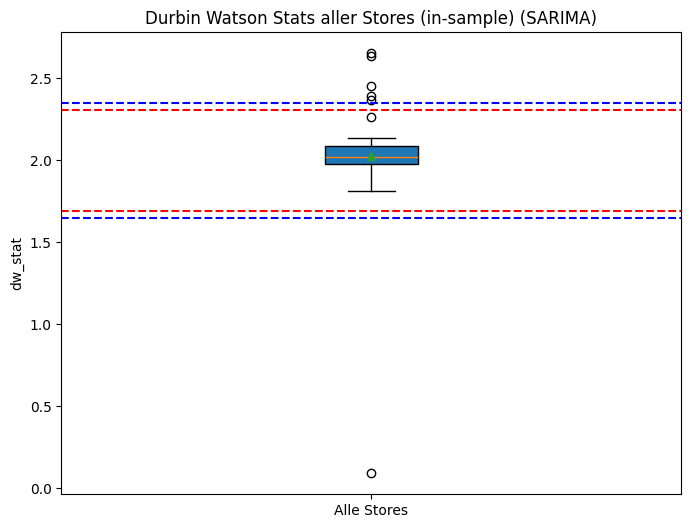

Mittelwert: 2.026073476589763
Median: 2.0194477690539565


In [8]:
dw_stats = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    resid = residuals_dict.get(store)
    if resid is not None:
        try:
            dw_stat = durbin_watson_test(resid, False)
            dw_stats.append(dw_stat)
        except Exception as e:
            print(f"Fehler beim Durbin Watson Test für Store {store}: {e}")
            dw_stats.append(np.nan)
    else:
        dw_stats.append(np.nan)

print(dw_stats)

# Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(dw_stats, patch_artist=True, showmeans=True)
plt.title('Durbin Watson Stats aller Stores (in-sample) ({})'.format(model_type))
plt.ylabel("dw_stat")
plt.xticks([1], ["Alle Stores"])
plt.axhline(1.69, color='red', linestyle='--', label='dU')
plt.axhline(4-1.69, color='red', linestyle='--', label='4-dU')
plt.axhline(1.65, color='blue', linestyle='--', label='dL')
plt.axhline(4-1.65, color='blue', linestyle='--', label='4-dL')
plt.show()

# Mittelwerte und Median der p-Werte
print("Mittelwert:", np.mean(dw_stats))
print("Median:", np.median(dw_stats))


ACF Plots

[1, 1, 0, 3, 1, 0, 20, 2, 0, 2, 1, 2, 1, 0, 2, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 3, 1, 1, 15, 1, 1, 12, 1, 1, 1, 0, 1, 4, 0, 1, 0]
45


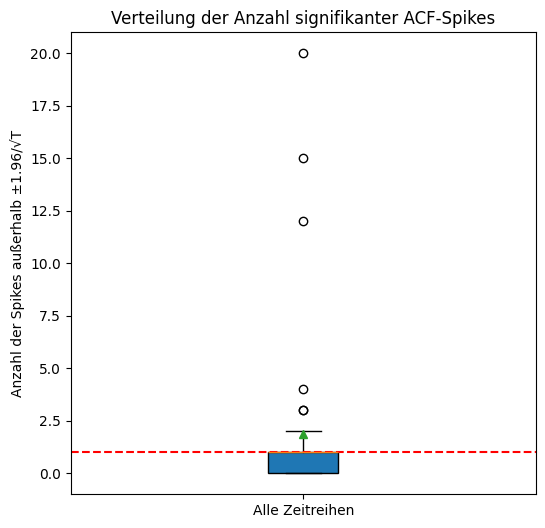

In [9]:

spikes = {}
for store in range(1, 46):
    resid = residuals_dict.get(store)
    spikes[store] = count_spikes(resid, lags = 20)
    #print(spikes[store])


values = list(spikes.values())
print(values)
print(len(values))

plt.figure(figsize=(6, 6))
plt.boxplot(values, patch_artist=True, showmeans=True)
plt.title("Verteilung der Anzahl signifikanter ACF-Spikes")
plt.ylabel("Anzahl der Spikes außerhalb ±1.96/√T")
plt.xticks([1], ["Alle Zeitreihen"])
plt.axhline(20*0.05, color='red', linestyle='--')
plt.show()



Mittelwert Tests

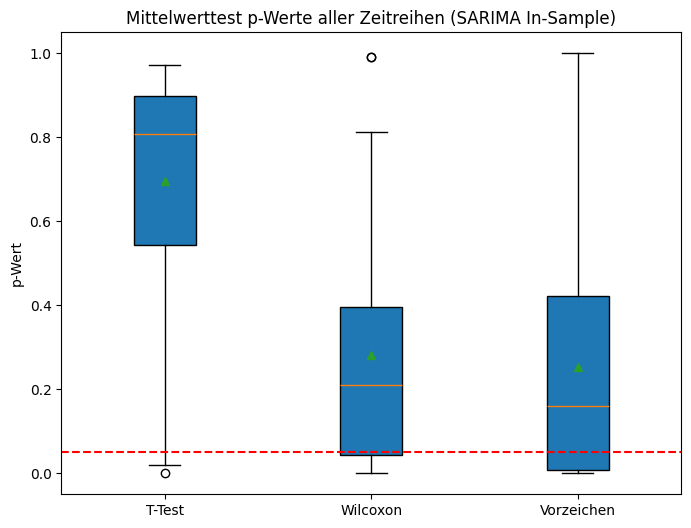

T-TEST Mittelwert: 0.6959557597147025 Median: 0.8075536854171214 Standardabweichung: 0.2852110057969684 Annahme (%): 93.33333333333333
WILCOXON Mittelwert: 0.2810416829555537 Median: 0.2092862309291928 Standardabweichung: 0.2853164329803299 Annahme (%): 71.11111111111111
VORZEICHEN Mittelwert: 0.2538391347026962 Median: 0.15906965188123803 Standardabweichung: 0.3015512226973994 Annahme (%): 57.77777777777777


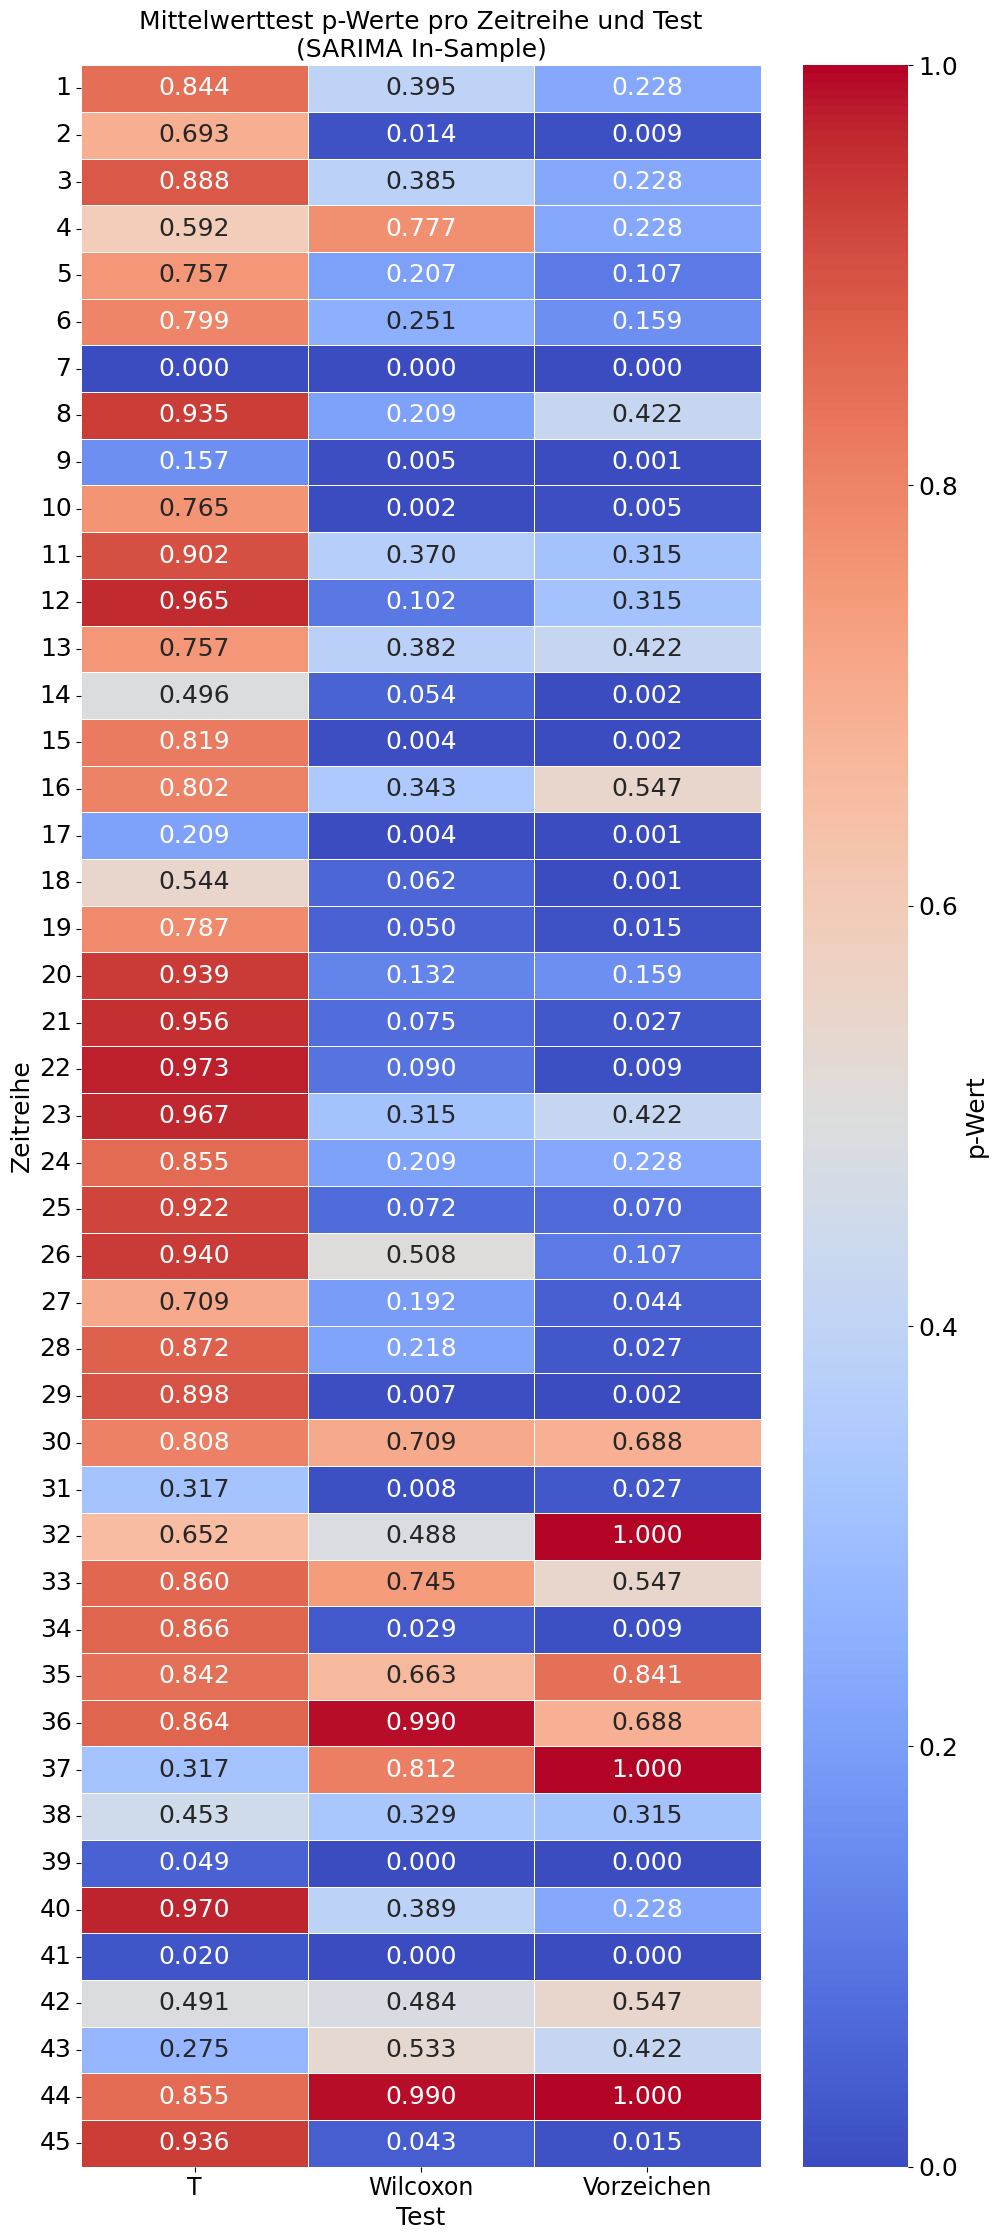

In [10]:
t_pvalues = []
w_pvalues = []
b_pvalues = []
k_pvalues = []
z_pvalues = []
s_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    resid = residuals_dict.get(store)
    if resid is not None:
        # T-Test
        try:
            _, p_value = t_test(resid, False)
            t_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim t-Test für Store {store}: {e}")
            t_pvalues.append(np.nan)
        # Wilcoxon Test
        try:
            _, p_value = wilcoxon_test(resid, False)
            w_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Wilcoxon Test für Store {store}: {e}")
            w_pvalues.append(np.nan)
        # Binomial Test
        try:
            _, _, p_value = binomial_test(resid, False)
            b_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Binomial Test für Store {store}: {e}")
            b_pvalues.append(np.nan)
        # Sign Test
        try:
            _, s_value = vorzeichen_test(resid, False)
            s_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Sign Test für Store {store}: {e}")
            s_pvalues.append(np.nan)
        # Kolmogorov Test
        try:
            _, p_value = kolmogorov_test(resid, False)
            k_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Kolmogorov Test für Store {store}: {e}")
            k_pvalues.append(np.nan)
        # Z-Test
        try:
            _, p_value = z_test(resid, False)
            z_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Z-Test für Store {store}: {e}")
            z_pvalues.append(np.nan)
    else:
        t_pvalues.append(np.nan)
        w_pvalues.append(np.nan)
        b_pvalues.append(np.nan)
        k_pvalues.append(np.nan)
        z_pvalues.append(np.nan)


pvalues = np.column_stack([t_pvalues, w_pvalues, s_pvalues])
#print(pvalues)

# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(pvalues, patch_artist=True, showmeans=True)
plt.title('Mittelwerttest p-Werte aller Zeitreihen (SARIMA In-Sample)')
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3], ["T-Test", "Wilcoxon", "Vorzeichen"])
plt.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
plt.ylim(-0.05, 1.05)
plt.show()


print('T-TEST Mittelwert:', pd.Series(t_pvalues).mean(), 
      'Median:', pd.Series(t_pvalues).median(),
      'Standardabweichung:', pd.Series(t_pvalues).std(),
      'Annahme (%):', (pd.Series(t_pvalues) >= 0.05).mean() * 100)
print('WILCOXON Mittelwert:', pd.Series(w_pvalues).mean(),
      'Median:', pd.Series(w_pvalues).median(),
      'Standardabweichung:', pd.Series(w_pvalues).std(),
      'Annahme (%):', (pd.Series(w_pvalues) >= 0.05).mean() * 100)
print('VORZEICHEN Mittelwert:', pd.Series(s_pvalues).mean(),
      'Median:', pd.Series(s_pvalues).median(),
      'Standardabweichung:', pd.Series(s_pvalues).std(),
      'Annahme (%):', (pd.Series(s_pvalues) >= 0.05).mean() * 100)


# Heatmap der p-Werte
store_names = [f"{i+1}" for i in range(pvalues.shape[0])]
columns = ["T", "Wilcoxon", "Vorzeichen"]
df_pvalues = pd.DataFrame(pvalues, index=store_names, columns=columns)

plt.figure(figsize=(10, len(store_names) * 0.5))
ax = sns.heatmap(
    df_pvalues,
    annot=True,
    fmt=".3f",
    annot_kws={"size": 18},
    cmap="coolwarm",
    cbar_kws={'label': 'p-Wert'},
    vmin=0,
    vmax=1,
    linewidths=0.7,         # Breite der Linien zwischen den Zellen
    linecolor='white'     # Farbe der Linien
)

# Colorbar
cbar = ax.collections[0].colorbar
# Tick-Labels der Colorbar
cbar.ax.tick_params(labelsize=18)
# Label der Colorbar (p-Wert)
cbar.set_label('p-Wert', fontsize=18)
# Achsen-Tick-Labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=17)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=18)
# Titel und Achsenbeschriftungen
plt.title(
    'Mittelwerttest p-Werte pro Zeitreihe und Test\n'
    '(SARIMA In-Sample)',
    fontsize=18
)
plt.xlabel("Test", fontsize=18)
plt.ylabel("Zeitreihe", fontsize=18)

plt.tight_layout()
plt.show()



SMAPE

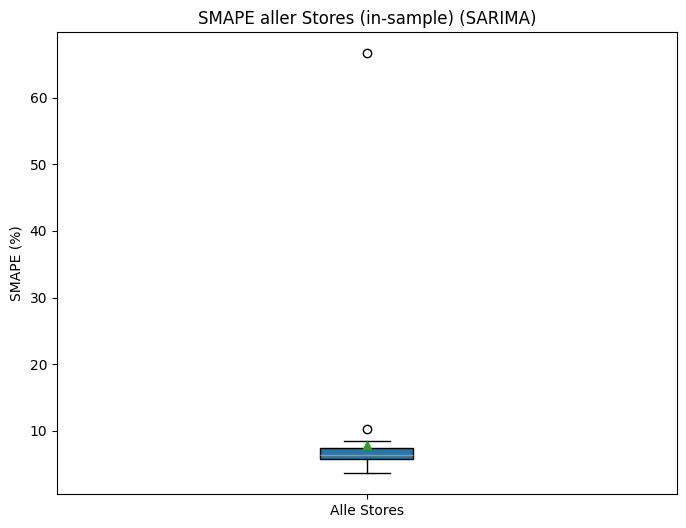

Mittelwert: 7.805833321102384 %
Median: 6.408989080660721 %
[5.524379303846867, 5.7135244628169355, 5.752694056287214, 6.0075265424497335, 5.93447527536663, 6.408989080660721, 66.66135848167502, 5.227495477785666, 7.246240596871156, 5.729598248237823, 5.61193778218609, 5.691035471791909, 5.702818587792704, 7.318043724738732, 7.42754803625372, 6.709174556398763, 8.213114531970824, 8.302728531204313, 6.220621497912913, 6.50536732036214, 7.24836460922831, 6.824080515560936, 8.527390137158884, 6.591644996794345, 6.185293526195202, 5.900876888863751, 7.402104284019412, 7.798645733955769, 7.892464559033481, 3.6331865683099487, 5.869326149160838, 5.191729441534381, 7.419021799532051, 5.028974288481798, 10.320374766494487, 4.968831283690765, 4.276775946367701, 5.872007052313983, 7.7288628313044185, 6.732960957683002, 8.06819855465879, 7.030826377649967, 5.20247075966762, 4.666849915732523, 6.972565939604988]


In [11]:

smape_stats = []

for store in range(1, 46):
    y_train = y_train_dict.get(store) # wahre Werte
    fitted = fitted_values_dict.get(store) # geschätzte Werte

    # SMAPE berechnen

    denom = (np.abs(y_train) + np.abs(fitted))
    # Vermeide Division durch 0
    mask = denom != 0
    smape = 100 * np.mean(2 * np.abs(fitted[mask] - y_train[mask]) / denom[mask])
    smape_stats.append(smape)

# Boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(smape_stats, patch_artist=True, showmeans=True)
plt.title(f'SMAPE aller Stores (in-sample) ({model_type})')
plt.ylabel("SMAPE (%)")
plt.xticks([1], ["Alle Stores"])
#plt.ylim(-0.05, 1.05)
plt.show()

# Mittelwerte und Median der SMAPE Werte
print("Mittelwert:",np.mean(smape_stats), "%")
print("Median:",np.median(smape_stats), "%")
print(smape_stats)

SMAPE vs. Autokorrelation p-Werte

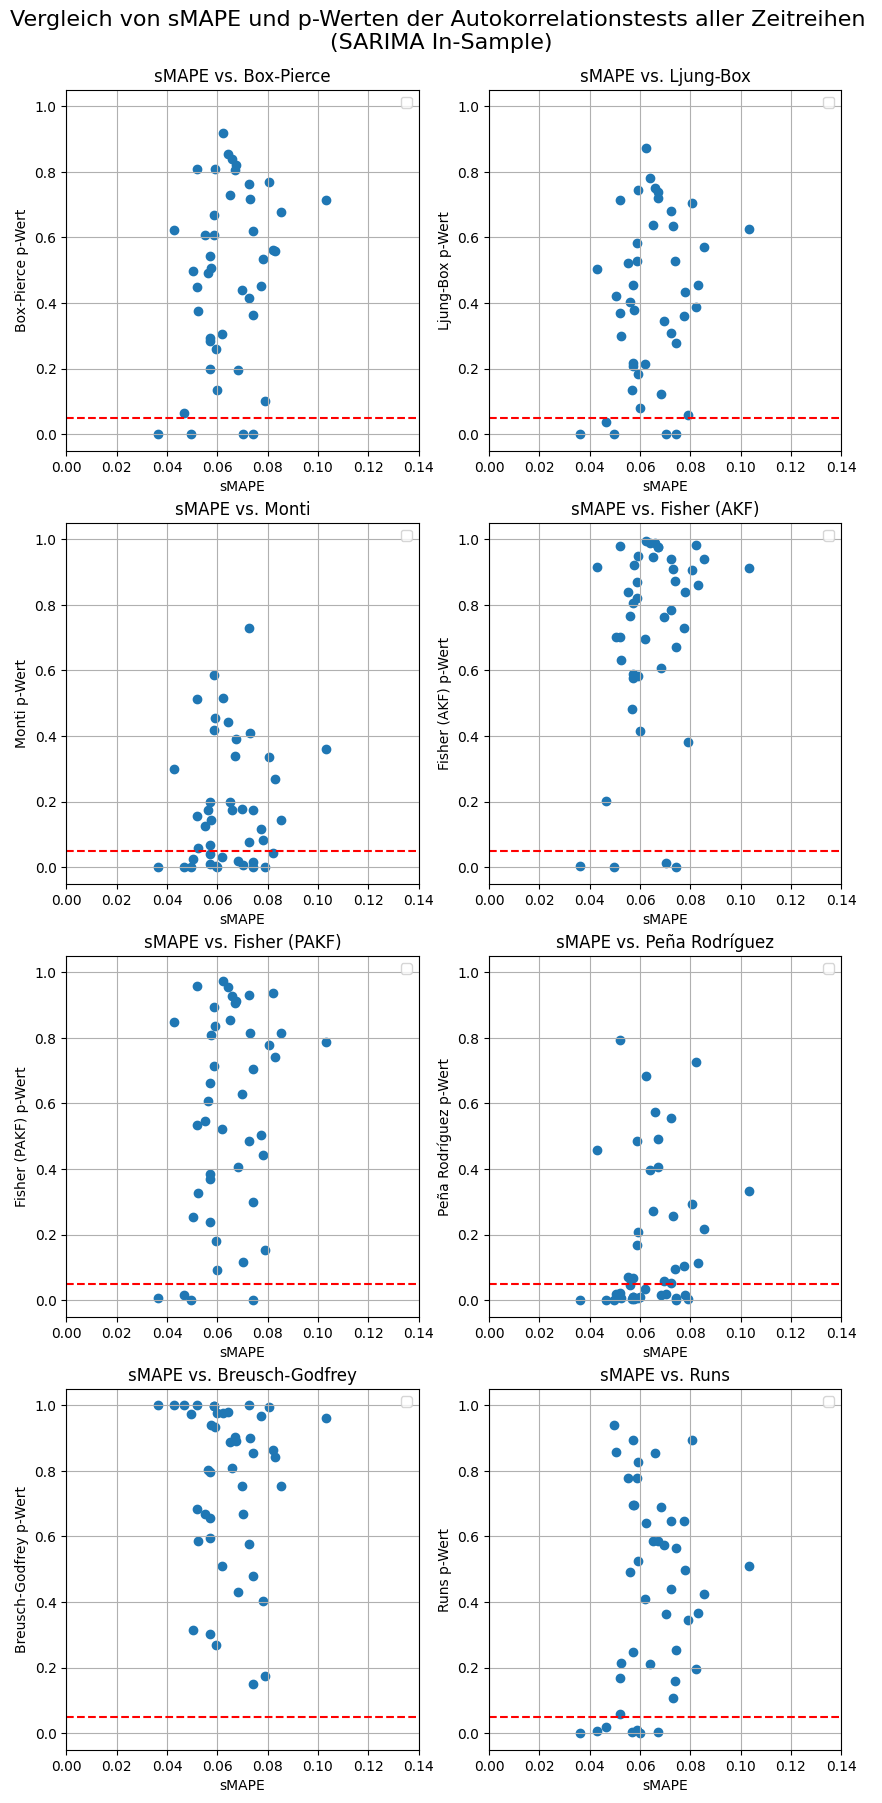

[[0.6086626009929421, 0.28346499525144214, 0.5063421687498042, 0.13410265977109193, 0.26068447649750526, 0.8542259389199671, 2.7639486711600042e-123, 0.37574905977611844, 0.7636642339404092, 0.29178184447789296, 0.490721877370187, 0.19792571910301066, 0.5422591447359882, 0.7155154883946923, 0.36299251337796107, 0.8039984573067687, 0.5621692492786579, 0.5568862482092649, 0.9187987577625149, 0.7292961992590936, 0.41510393287280606, 0.197026552731646, 0.6778405483529695, 0.8373136981208347, 0.3069016288027343, 0.8080249537488138, 0.6188554045529014, 0.5342926922727705, 0.10247411285298991, 0.00043229453303257647, 0.6082447448501047, 0.44900503011837456, 1.9596526208043047e-32, 0.49696478027547375, 0.7130712987144807, 1.5115378681399145e-16, 0.6213651957303437, 0.6687219399093243, 0.45196076817550185, 0.819745568768242, 0.7685092375781511, 3.45494424924122e-05, 0.8083899804916003, 0.06380993770097326, 0.44082684579567705], [0.5226243758173564, 0.20888346049021295, 0.37729690385407705, 0.08

In [12]:
fig, axes = plt.subplots(4, 2, figsize=(10, 20))  # 2 Zeilen, 4 Spalten

smape_dec = np.asarray(smape_stats) / 100
p_values_list = [bp_pvalues, lb_pvalues, m_pvalues, f_pvalues, f2_pvalues, pr_pvalues, bg_pvalues, rt_pvalues]
test_names = ["Box-Pierce", "Ljung-Box", "Monti", "Fisher (AKF)", "Fisher (PAKF)", "Peña Rodríguez", "Breusch-Godfrey", "Runs"]

for i, ax in enumerate(axes.flat):
    ax.scatter(smape_dec, p_values_list[i])
    ax.set_xlabel('sMAPE')
    ax.set_ylabel(f'{test_names[i]} p-Wert')
    ax.set_title(f'sMAPE vs. {test_names[i]}')
    ax.grid(True)
    ax.axhline(0.05, color='red', linestyle='--')
    ax.legend()
    ax.set_xlim(0, 0.14)
    ax.set_ylim(-0.05, 1.05)


fig.suptitle('Vergleich von sMAPE und p-Werten der Autokorrelationstests aller Zeitreihen \n'
    '(SARIMA In-Sample)', fontsize=16)
#plt.tight_layout()
fig.subplots_adjust(top=0.94)
plt.show()


print(p_values_list)

SMAPE vs Mittelwert p-Werte

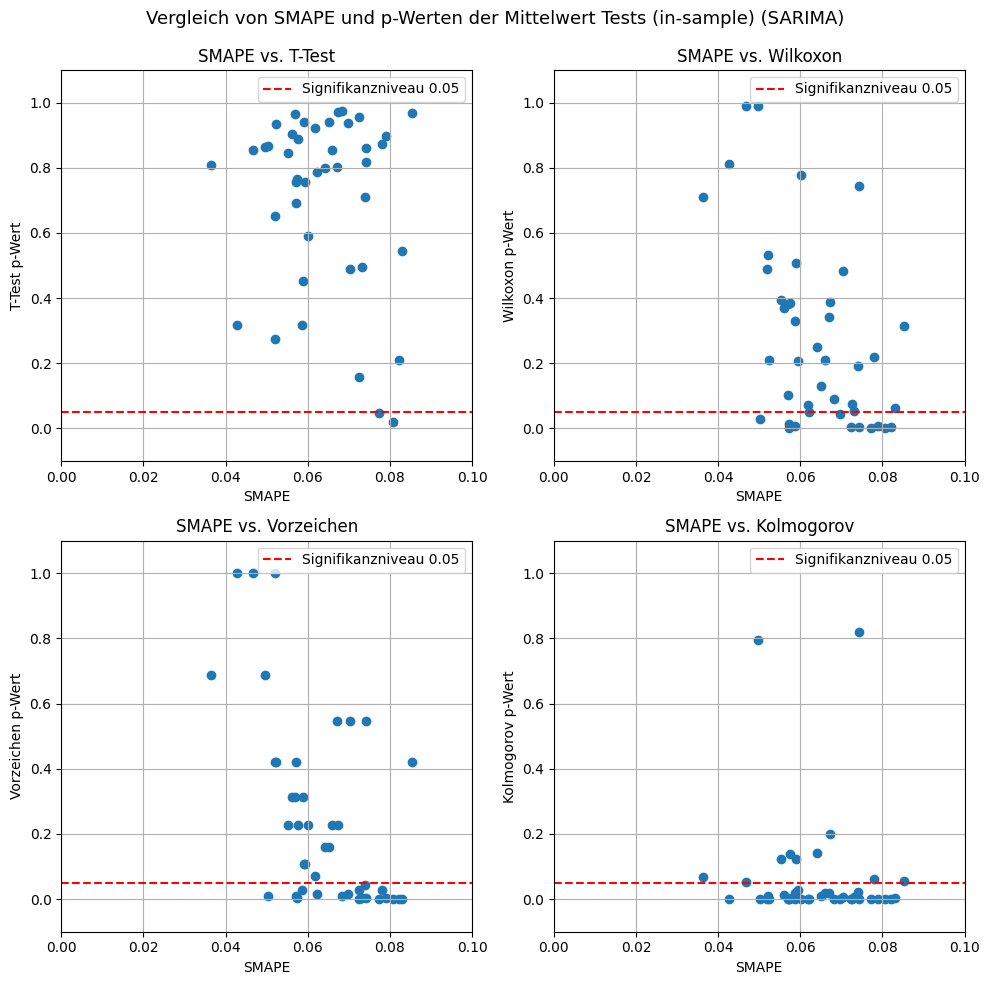

[[0.8443131538112725, 0.6928944254275946, 0.8884407023337793, 0.5917282499466804, 0.7565423342422103, 0.7986432567289501, 1.2820707965522457e-15, 0.9350761535816046, 0.15704455293987205, 0.7649176738849274, 0.9024500361664843, 0.964674353118329, 0.7571219233907694, 0.49577156973316616, 0.8191105555159309, 0.801997535085663, 0.20915411152909338, 0.5442464973130661, 0.7867337922168184, 0.9391050918696319, 0.955753170759956, 0.9731397363439533, 0.9668485999403436, 0.855342615641052, 0.9221726863278514, 0.9400218149698109, 0.709498961053386, 0.8724459560120522, 0.8984377684562153, 0.8075536854171214, 0.3168740415875279, 0.6524304968854213, 0.8604679843151786, 0.8656917568955411, 0.8421269373022153, 0.8639263614054162, 0.3165315686255565, 0.45289071631362243, 0.0488461812095221, 0.9701122282903931, 0.0201277308072345, 0.4906580263852376, 0.2748402752170233, 0.8552378293233802, 0.9360660888407513], [0.3950836069092198, 0.01389790217702503, 0.3854682700490862, 0.7770208624957193, 0.2067582403

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

smape_dec = np.asarray(smape_stats) / 100
p_values_list = [t_pvalues, w_pvalues, s_pvalues, k_pvalues]
test_names = ["T-Test", "Wilkoxon", "Vorzeichen", "Kolmogorov"]

for i, ax in enumerate(axes.flat):
    ax.scatter(smape_dec, p_values_list[i])
    ax.set_xlabel('SMAPE')
    ax.set_ylabel(f'{test_names[i]} p-Wert')
    ax.set_title(f'SMAPE vs. {test_names[i]}')
    ax.grid(True)
    ax.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
    ax.legend()
    ax.set_xlim(0, 0.1)
    ax.set_ylim(-0.1, 1.1)


fig.suptitle('Vergleich von SMAPE und p-Werten der Mittelwert Tests (in-sample) ({})'.format(model_type), fontsize=13)
plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()


p_values_list_new = [t_pvalues, w_pvalues, s_pvalues]
print(p_values_list_new)

Errors

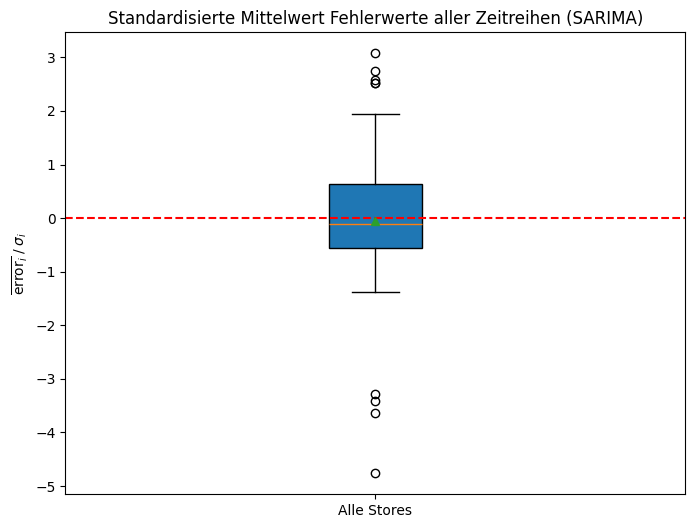

Mittelwert:  -0.0528969922131968
Median:  -0.11470441907353213
[-0.7666313152711037, -0.3320326614616644, -0.9988726623815785, 0.38341086329854396, -1.175004214765247, -0.13536380293031267, 0.891787408444965, -0.5005226409130464, 2.525629120719219, 0.41292115879751456, -0.40399673474732745, -0.3460926527638689, -0.734602538270952, 1.3243973559000062, 0.8978126681039309, 0.1427922361064132, 1.9483046243293571, 0.0019462493760531673, 0.6380717604162861, -0.20301380899395557, 1.601687339326696, 0.2582863026320993, -0.20273214657100477, 0.048790984477889814, -0.11470441907353213, -0.27716690288334156, 1.0121910179213653, 0.24380343483916192, 0.2742716417519505, -4.7632545254718535, 2.5283735278902073, -0.5332669727285809, -3.2820047959417926, -0.549890393197812, 2.584609654625702, -3.414531704818542, -1.3856510693592397, -0.6386735135766252, 2.752346004111709, -0.11450850626849424, 3.0763406271247526, -0.4904909477774363, -1.1668800411197915, -3.641759182605625, 0.24350952410504803]


In [14]:
error_bias = [] 
for store in sorted(errors_dict.keys(), key=int):
    error = errors_dict[store]
    #print(len(error))
    mean = error.mean()
    std = error.std(ddof=0)        # Populations-Std (ddof=0)
    if std == 0:
        error_bias.append(np.nan)
    else:
        error_bias.append(mean / std) # standardisierter Bias

plt.figure(figsize=(8, 6))
plt.boxplot(error_bias, patch_artist=True, showmeans=True)
plt.title('Standardisierte Mittelwert Fehlerwerte aller Zeitreihen ({})'.format(model_type))
plt.ylabel(r'$\overline{\mathrm{error}_i}\; / \;\sigma_i$')
plt.xticks([1], ['Alle Stores'])
plt.axhline(0, color ='red', ls='--')
plt.show()

print("Mittelwert: ", np.mean(error_bias))
print("Median: ", np.median(error_bias))
print(error_bias)


Korrelations Test

Fehler beim Pena Rodriguez Test für Store 2: float division by zero
Fehler beim Pena Rodriguez Test für Store 8: float division by zero
Fehler beim Pena Rodriguez Test für Store 10: float division by zero
Fehler beim Pena Rodriguez Test für Store 11: float division by zero
Fehler beim Pena Rodriguez Test für Store 12: float division by zero
Fehler beim Pena Rodriguez Test für Store 13: float division by zero
Fehler beim Pena Rodriguez Test für Store 15: float division by zero
Fehler beim Pena Rodriguez Test für Store 16: float division by zero
Fehler beim Pena Rodriguez Test für Store 18: float division by zero
Fehler beim Pena Rodriguez Test für Store 19: float division by zero
Fehler beim Pena Rodriguez Test für Store 20: float division by zero
Fehler beim Pena Rodriguez Test für Store 22: float division by zero
Fehler beim Pena Rodriguez Test für Store 23: float division by zero
Fehler beim Pena Rodriguez Test für Store 25: float division by zero
Fehler beim Pena Rodriguez Test für 

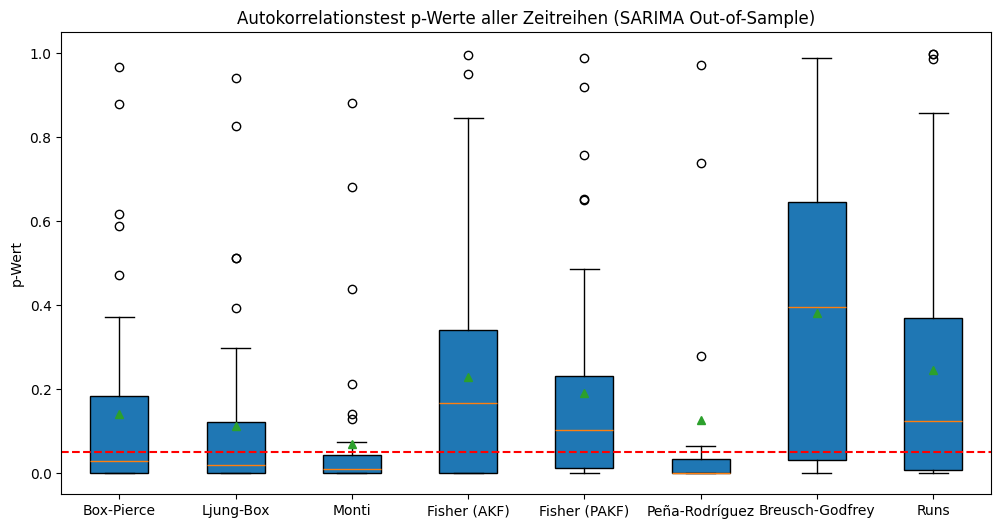

BOX-PIERCE Mittelwert: 0.13944270322059787 Median: 0.027324868126016023 Standardabweichung: 0.2302834505081868 Annahme (%): 44.44444444444444
LJUNG-BOX Mittelwert: 0.11187814365109018 Median: 0.017989229214494983 Standardabweichung: 0.2115801057137177 Annahme (%): 37.77777777777778
MONTI Mittelwert: 0.0683006843648732 Median: 0.008414367770145703 Standardabweichung: 0.1734410936181633 Annahme (%): 20.0
FISHER (AKF) Mittelwert: 0.22908086782266315 Median: 0.16589865037752483 Standardabweichung: 0.2787966738603142 Annahme (%): 53.333333333333336
FISHER (PAKF) Mittelwert: 0.189985392858673 Median: 0.10104633758041315 Standardabweichung: 0.2531589338707947 Annahme (%): 60.0
PEÑA-RODRIGUEZ Mittelwert: 0.12483917540697984 Median: 0.0002534562778219174 Standardabweichung: 0.2856131939189791 Annahme (%): 23.52941176470588
BREUSCH-GODFREY Mittelwert: 0.3792626699394677 Median: 0.39360934003972187 Standardabweichung: 0.3358127660571852 Annahme (%): 71.11111111111111
RUNS Mittelwert: 0.2442889110

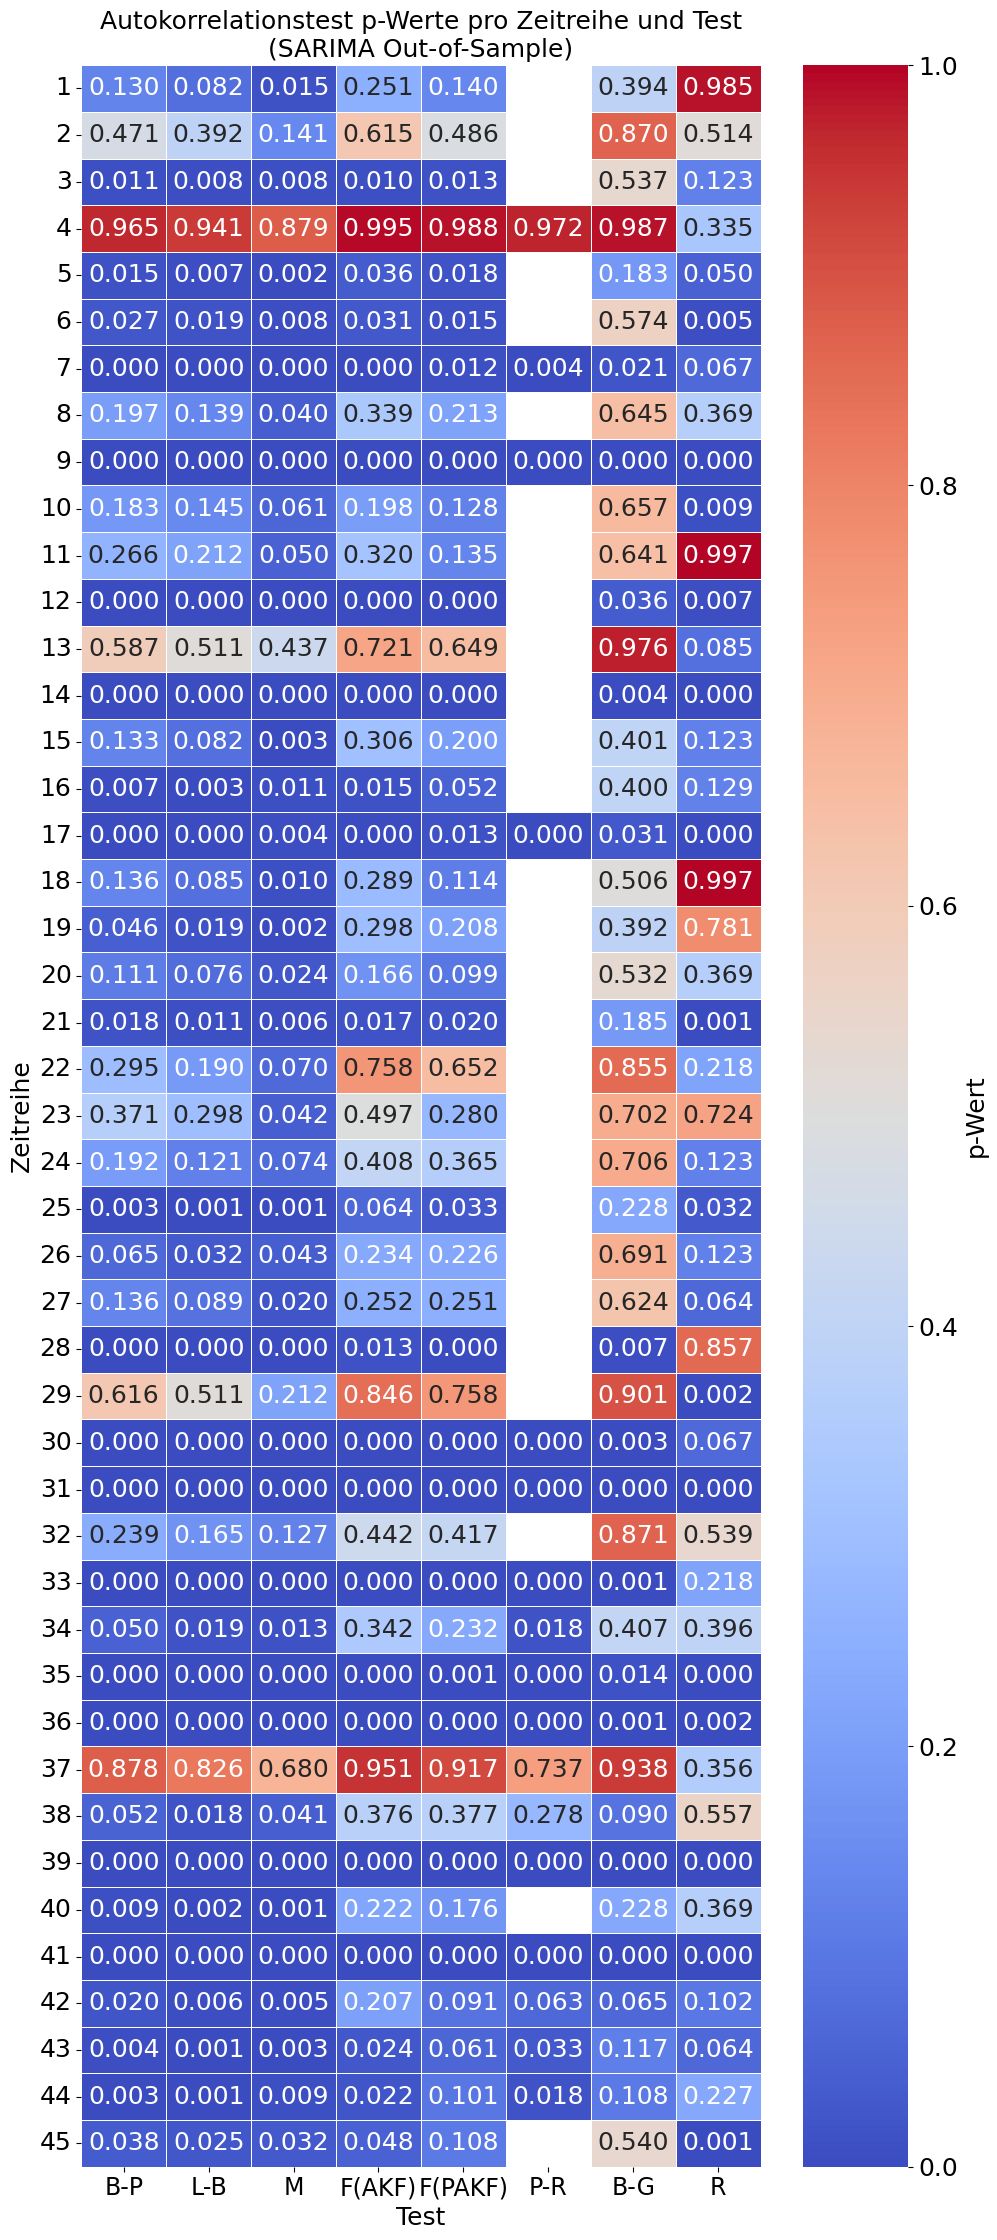

In [15]:
bp_pvalues = []
lb_pvalues = []
bg_pvalues = []
rt_pvalues = []
m_pvalues = []
f_pvalues = []
f2_pvalues = []
pr_pvalues = []
pr2_pvalues = []


# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    errors = errors_dict[store]
    #print(len(errors))
    
    sales = df[df['store'] == store].copy() #Zeitreihe für den Store
    sales.set_index('date', inplace=True)
    sales = sales['weekly_sales']
    sales = sales.asfreq('W-FRI')

    if errors is not None:
        # Box-Pierce Test
        try:
            _, p_value = box_pierce_test(residuals = errors, store_num = store, model = model_type, sample = "OOS", lags = 9, print_results=False)
            bp_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Box-Pierce Test für Store {store}: {e}")
            bp_pvalues.append(np.nan)
        # Ljung-Box Test
        try:
            _, p_value = ljung_box_test(residuals = errors, store_num = store, model = model_type, sample = "OOS", lags = 9, print_results=False)
            lb_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Ljung-Box Test für Store {store}: {e}")
            lb_pvalues.append(np.nan)
        # Breusch-Godfrey Test
        try:
            _, p_value = breusch_godfrey_manuell(errors=errors, lags = 9, print_results= False)
            bg_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Breusch-Godfrey Test für Store {store}: {e}")
            bg_pvalues.append(np.nan)
        # Monti Test
        try:
            sarima_params  = optimal_orders_5.get(str(store))
            order = tuple(sarima_params["order"])
            _, p_value = monti_test(residuals = errors, store_num = store, model = model_type, m = 9, print_results = False)
            m_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Monti Test für Store {store}: {e}")
            m_pvalues.append(np.nan)
        # Fisher Test (ACF)
        try:
            _, p_value = fisher_test(residuals = errors, store_num = store, model = model_type, version = "acf", m = 9, print_results = False)
            f_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Fisher Test für Store {store}: {e}")
            f_pvalues.append(np.nan)
        # Fisher Test (PACF)
        try:
            _, p_value = fisher_test(residuals = errors, store_num = store, model = model_type, version = "pacf", m = 9, print_results = False)
            f2_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Fisher Test für Store {store}: {e}")
            f2_pvalues.append(np.nan)
        # Pena Rodriguez Test (Monte Carlo)
        try:
            _, p_value = pena_rodriguez_test_mc(residuals = errors, m = 9, print_results= False)
            pr2_pvalues.append(p_value)

        except Exception as e:
            print(f"Fehler beim Pena Rodriguez Test für Store {store}: {e}")
            pr2_pvalues.append(np.nan)
        # Pena Rodriguez Test (normal)
        try:
            _, p_value = pena_rodriguez_test_original(residuals = errors, store_num = store, model = model_type, m = 9, print_results= False)
            pr_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Pena Rodriguez Test für Store {store}: {e}")
            pr_pvalues.append(np.nan)
        # Runs Test
        try:
            _, p_value = run_test(residuals = errors, print_results=False)
            rt_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Runs Test für Store {store}: {e}")
            rt_pvalues.append(np.nan)
    else:
        bp_pvalues.append(np.nan)
        lb_pvalues.append(np.nan)
        bg_pvalues.append(np.nan)
        rt_pvalues.append(np.nan)
        m_pvalues.append(np.nan)
        f_pvalues.append(np.nan)
        f2_pvalues.append(np.nan)
        pr_pvalues.append(np.nan)


#pr_pvalues.dropna()
pvalues = np.column_stack([bp_pvalues, lb_pvalues, m_pvalues, f_pvalues, f2_pvalues, pr_pvalues, bg_pvalues, rt_pvalues])

arr = np.array(pr_pvalues)
pr_clean = arr[~np.isnan(arr)]


all_pvalues = [
    bp_pvalues,
    lb_pvalues,
    m_pvalues,
    f_pvalues,
    f2_pvalues,
    pr_clean,
    bg_pvalues,
    rt_pvalues
]

#print(pr_clean)

# Boxplot aller p-Werte
plt.figure(figsize=(12, 6))
plt.boxplot(all_pvalues, patch_artist=True, showmeans=True)
plt.title('Autokorrelationstest p-Werte aller Zeitreihen (SARIMA Out-of-Sample)')
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8], ["Box-Pierce", "Ljung-Box",  "Monti", "Fisher (AKF)", "Fisher (PAKF)", "Peña-Rodríguez", "Breusch-Godfrey", "Runs"])
plt.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
plt.ylim(-0.05, 1.05)
plt.show()

print('BOX-PIERCE Mittelwert:', pd.Series(bp_pvalues).mean(), 
      'Median:', pd.Series(bp_pvalues).median(),
      'Standardabweichung:', pd.Series(bp_pvalues).std(),
      'Annahme (%):', (pd.Series(bp_pvalues) >= 0.05).mean() * 100)
print('LJUNG-BOX Mittelwert:', pd.Series(lb_pvalues).mean(),
      'Median:', pd.Series(lb_pvalues).median(),
      'Standardabweichung:', pd.Series(lb_pvalues).std(),
      'Annahme (%):', (pd.Series(lb_pvalues) >= 0.05).mean() * 100)
print('MONTI Mittelwert:', pd.Series(m_pvalues).mean(),
      'Median:', pd.Series(m_pvalues).median(),
      'Standardabweichung:', pd.Series(m_pvalues).std(),
      'Annahme (%):', (pd.Series(m_pvalues) >= 0.05).mean() * 100)
print('FISHER (AKF) Mittelwert:', pd.Series(f_pvalues).mean(),
      'Median:', pd.Series(f_pvalues).median(),
      'Standardabweichung:', pd.Series(f_pvalues).std(),
      'Annahme (%):', (pd.Series(f_pvalues) >= 0.05).mean() * 100)
print('FISHER (PAKF) Mittelwert:', pd.Series(f2_pvalues).mean(),
      'Median:', pd.Series(f2_pvalues).median(),
      'Standardabweichung:', pd.Series(f2_pvalues).std(),
      'Annahme (%):', (pd.Series(f2_pvalues) >= 0.05).mean() * 100)
print('PEÑA-RODRIGUEZ Mittelwert:', (pd.Series(pr_pvalues).dropna()).mean(),
      'Median:', (pd.Series(pr_pvalues).dropna()).median(),
      'Standardabweichung:', (pd.Series(pr_pvalues).dropna()).std(),
      'Annahme (%):', (pd.Series(pr_pvalues).dropna() >= 0.05).sum() / (pd.Series(pr_pvalues).dropna()).count() * 100)
print('BREUSCH-GODFREY Mittelwert:', pd.Series(bg_pvalues).mean(),
      'Median:', pd.Series(bg_pvalues).median(),
      'Standardabweichung:', pd.Series(bg_pvalues).std(),
      'Annahme (%):', (pd.Series(bg_pvalues) >= 0.05).mean() * 100)
print('RUNS Mittelwert:', pd.Series(rt_pvalues).mean(),
      'Median:', pd.Series(rt_pvalues).median(),
      'Standardabweichung:', pd.Series(rt_pvalues).std(),
      'Annahme (%):', (pd.Series(rt_pvalues) >= 0.05).mean() * 100)


# Heatmap der p-Werte
store_names = [f"{i+1}" for i in range(pvalues.shape[0])]
columns = ["B-P", "L-B", "M", "F(AKF)",
           "F(PAKF)", "P-R", "B-G", "R"]
df_pvalues = pd.DataFrame(pvalues, index=store_names, columns=columns)

plt.figure(figsize=(10, len(store_names) * 0.5))
ax = sns.heatmap(
    df_pvalues,
    annot=True,
    fmt=".3f",
    annot_kws={"size": 18},
    cmap="coolwarm",
    cbar_kws={'label': 'p-Wert'},
    vmin=0,
    vmax=1,
    linewidths=0.7,         # Breite der Linien zwischen den Zellen
    linecolor='white'     # Farbe der Linien
)

# Colorbar
cbar = ax.collections[0].colorbar
# Tick-Labels der Colorbar
cbar.ax.tick_params(labelsize=18)
# Label der Colorbar (p-Wert)
cbar.set_label('p-Wert', fontsize=18)
# Achsen-Tick-Labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=17)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=18)
# Titel und Achsenbeschriftungen
plt.title(
    'Autokorrelationstest p-Werte pro Zeitreihe und Test\n'
    '(SARIMA Out-of-Sample)',
    fontsize=18
)
plt.xlabel("Test", fontsize=18)
plt.ylabel("Zeitreihe", fontsize=18)

plt.tight_layout()
plt.show()



Durbin Watson

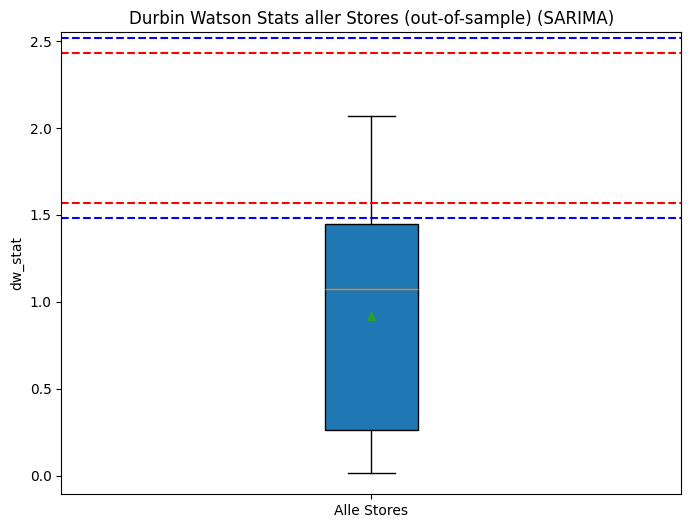

Mittelwert: 0.9205602621434167
Median: 1.0709902518674583
[1.000143118709763, 1.4504429494746167, 0.567719293313395, 1.670093847794387, 0.5004323942647618, 1.1731838525186116, 0.5130538377028483, 1.0998183065913743, 0.030118526984865855, 1.0252563171624138, 1.2217906478535563, 0.6124640056380971, 1.0709902518674583, 0.24137680144108534, 0.8330782193430717, 1.322290084897912, 0.12903799752375308, 1.5054976260422062, 1.3386127243506183, 1.5816701535836135, 0.26325710644993805, 1.7187651727562745, 1.6119044867731096, 1.5254073223427929, 1.4699313569242192, 1.578384947755234, 0.7234137500614894, 2.0683177792378604, 1.5818907004671108, 0.02601359635103221, 0.028316147461974445, 1.3465791326908414, 0.11588628086853199, 1.295445446404509, 0.09491559700229536, 0.05486027893975613, 0.5867295609557749, 1.2316635039474326, 0.021200324707326444, 1.9454711185270601, 0.013173689019428888, 1.4491765085360284, 0.5834479053645891, 0.09909209650056214, 1.1048970293501759]


In [16]:
dw_stats = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    error = errors_dict[store]
    if resid is not None:
        try:
            dw_stat = durbin_watson_test(error, False)
            dw_stats.append(dw_stat)
        except Exception as e:
            print(f"Fehler beim Durbin Watson Test für Store {store}: {e}")
            dw_stats.append(np.nan)
    else:
        dw_stats.append(np.nan)

# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(dw_stats, patch_artist=True, showmeans=True)
plt.title('Durbin Watson Stats aller Stores (out-of-sample) ({})'.format(model_type))
plt.ylabel("dw_stat")
plt.axhline(1.57, color='red', linestyle='--', label='dU')
plt.axhline(4-1.57, color='red', linestyle='--', label='4-dU')
plt.axhline(1.48, color='blue', linestyle='--', label='dL')
plt.axhline(4-1.48, color='blue', linestyle='--', label='4-dL')
plt.xticks([1], ["Alle Stores"])
plt.show()

print("Mittelwert:", np.mean(dw_stats))
print("Median:", np.median(dw_stats))
print(dw_stats)


ACF Plots

[0, 0, 1, 0, 2, 1, 5, 0, 8, 1, 0, 2, 0, 7, 0, 1, 6, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 4, 8, 0, 5, 1, 7, 6, 0, 1, 8, 1, 8, 2, 2, 2, 1]
45


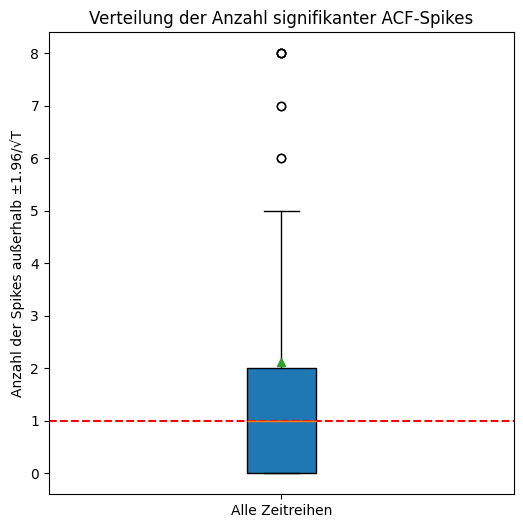

In [17]:
spikes = {}
for store in range(1, 46):
    error = errors_dict.get(store)
    spikes[store] = count_spikes(error, lags = 8)
    #print(spikes[store])


values = list(spikes.values())
print(values)
print(len(values))

plt.figure(figsize=(6, 6))
plt.boxplot(values, patch_artist=True, showmeans=True)
plt.title("Verteilung der Anzahl signifikanter ACF-Spikes")
plt.ylabel("Anzahl der Spikes außerhalb ±1.96/√T")
plt.xticks([1], ["Alle Zeitreihen"])
plt.axhline(20*0.05, color='red', linestyle='--')
plt.show()

Mittelwert Tests

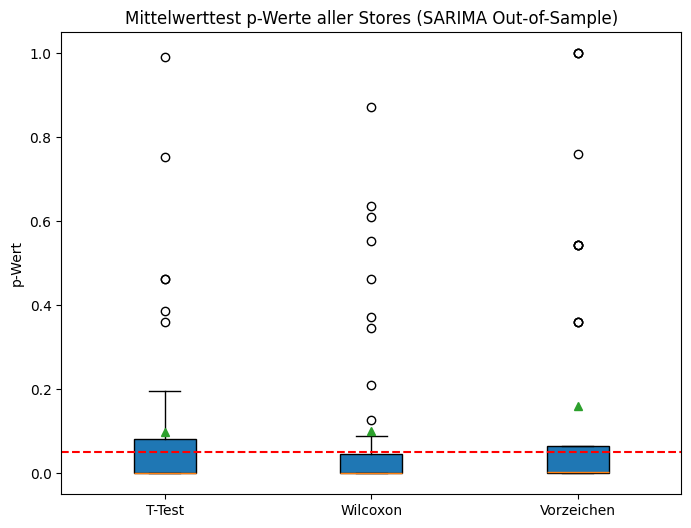

Mittelwerte: 0.09836330374668449 0.10012431774519731 0.1605592369465234
Mediane: 0.00016608630382308677 0.00031642533690501295 0.001913961001264397
T-TEST Mittelwert: 0.09836330374668449 Median: 0.00016608630382308677 Standardabweichung: 0.21049725188813295 Annahme (%): 28.888888888888886
WILCOXON Mittelwert: 0.10012431774519731 Median: 0.00031642533690501295 Standardabweichung: 0.21028229337203233 Annahme (%): 24.444444444444443
VORZEICHEN Mittelwert: 0.1605592369465234 Median: 0.001913961001264397 Standardabweichung: 0.30124418274162923 Annahme (%): 26.666666666666668


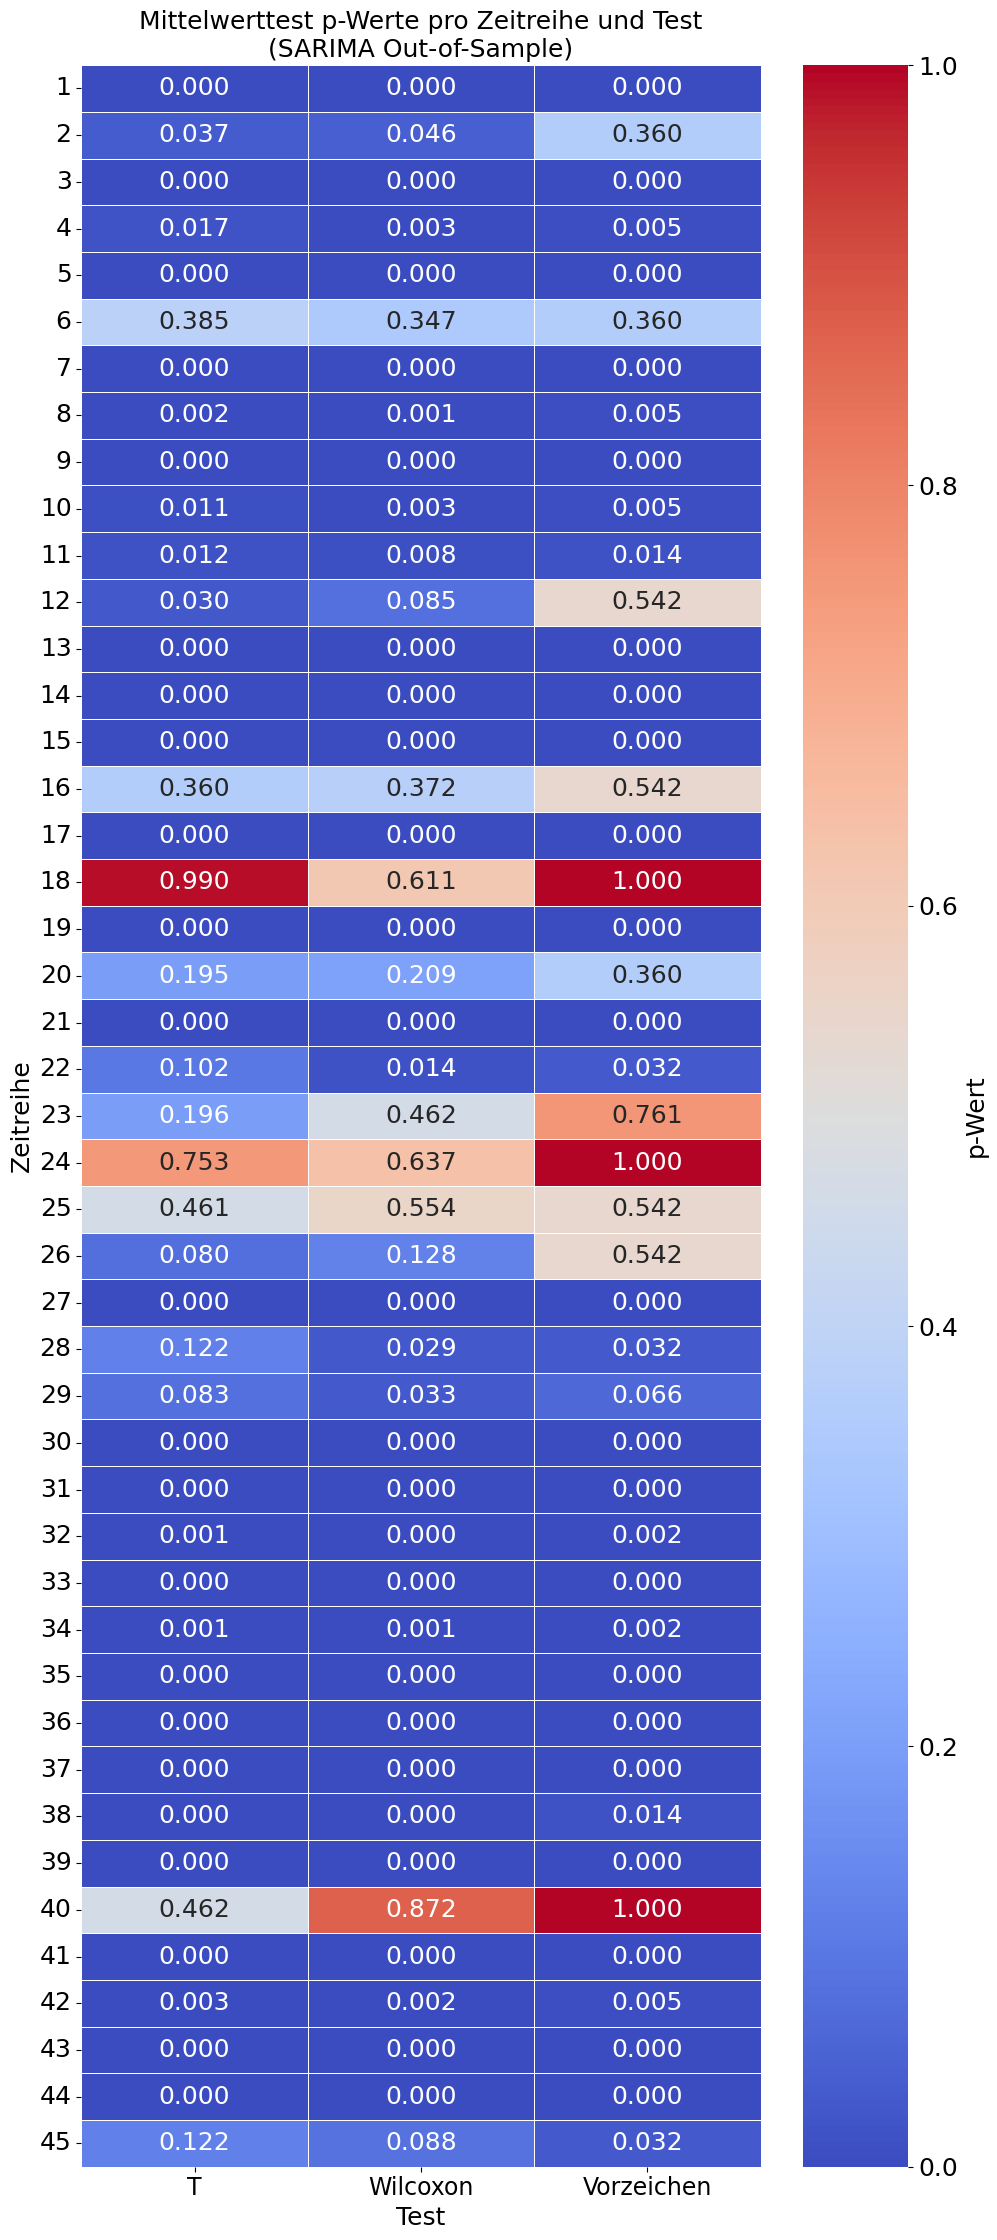

In [18]:
t_pvalues = []
w_pvalues = []
b_pvalues = []
k_pvalues = []
z_pvalues = []
s_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    errors = errors_dict[store]
    if resid is not None:
        # T-Test
        try:
            _, p_value = t_test(errors, False)
            t_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim t-Test für Store {store}: {e}")
            t_pvalues.append(np.nan)
        # Wilcoxon Test
        try:
            _, p_value = wilcoxon_test(errors, False)
            w_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Wilcoxon Test für Store {store}: {e}")
            w_pvalues.append(np.nan)
        # Binomial Test
        try:
            _, _, p_value = binomial_test(errors, False)
            b_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Binomial Test für Store {store}: {e}")
            b_pvalues.append(np.nan)
        # Sign Test
        try:
            _, s_value = vorzeichen_test(errors, False)
            s_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Sign Test für Store {store}: {e}")
            s_pvalues.append(np.nan)
        # Kolmogorov Test
        try:
            _, p_value = kolmogorov_test(errors, False)
            k_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Kolmogorov Test für Store {store}: {e}")
            k_pvalues.append(np.nan)
        # Z-Test
        try:
            _, p_value = z_test(errors, False)
            z_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Z-Test für Store {store}: {e}")
            z_pvalues.append(np.nan)
    else:
        t_pvalues.append(np.nan)
        w_pvalues.append(np.nan)
        b_pvalues.append(np.nan)
        k_pvalues.append(np.nan)
        z_pvalues.append(np.nan)


pvalues = np.column_stack([t_pvalues, w_pvalues, s_pvalues])


# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(pvalues, patch_artist=True, showmeans=True)
plt.title('Mittelwerttest p-Werte aller Stores (SARIMA Out-of-Sample)')
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3], ["T-Test", "Wilcoxon", "Vorzeichen"])
plt.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
plt.show()

# Mittelwerte und Median der p-Werte
print("Mittelwerte:", np.mean(t_pvalues), np.mean(w_pvalues), np.mean(s_pvalues))
print("Mediane:", np.median(t_pvalues), np.median(w_pvalues), np.median(s_pvalues))

print('T-TEST Mittelwert:', pd.Series(t_pvalues).mean(), 
      'Median:', pd.Series(t_pvalues).median(),
      'Standardabweichung:', pd.Series(t_pvalues).std(),
      'Annahme (%):', (pd.Series(t_pvalues) >= 0.05).mean() * 100)
print('WILCOXON Mittelwert:', pd.Series(w_pvalues).mean(),
      'Median:', pd.Series(w_pvalues).median(),
      'Standardabweichung:', pd.Series(w_pvalues).std(),
      'Annahme (%):', (pd.Series(w_pvalues) >= 0.05).mean() * 100)
print('VORZEICHEN Mittelwert:', pd.Series(s_pvalues).mean(),
      'Median:', pd.Series(s_pvalues).median(),
      'Standardabweichung:', pd.Series(s_pvalues).std(),
      'Annahme (%):', (pd.Series(s_pvalues) >= 0.05).mean() * 100)

# Heatmap der p-Werte
store_names = [f"{i+1}" for i in range(pvalues.shape[0])]
columns = ["T", "Wilcoxon", "Vorzeichen"]
df_pvalues = pd.DataFrame(pvalues, index=store_names, columns=columns)

plt.figure(figsize=(10, len(store_names) * 0.5))
ax = sns.heatmap(
    df_pvalues,
    annot=True,
    fmt=".3f",
    annot_kws={"size": 18},
    cmap="coolwarm",
    cbar_kws={'label': 'p-Wert'},
    vmin=0,
    vmax=1,
    linewidths=0.7,         # Breite der Linien zwischen den Zellen
    linecolor='white'     # Farbe der Linien
)

# Colorbar
cbar = ax.collections[0].colorbar
# Tick-Labels der Colorbar
cbar.ax.tick_params(labelsize=18)
# Label der Colorbar (p-Wert)
cbar.set_label('p-Wert', fontsize=18)
# Achsen-Tick-Labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=17)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=18)
# Titel und Achsenbeschriftungen
plt.title(
    'Mittelwerttest p-Werte pro Zeitreihe und Test\n'
    '(SARIMA Out-of-Sample)',
    fontsize=18
)
plt.xlabel("Test", fontsize=18)
plt.ylabel("Zeitreihe", fontsize=18)

plt.tight_layout()
plt.show()



SMAPE

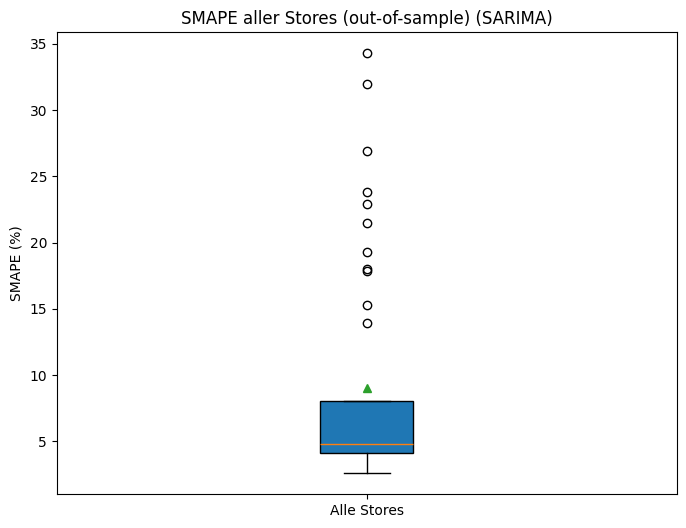

Mittelwert: 9.047903195962242 %
Median: 4.776568355782302 %
[4.517936301890902, 3.0689881742400966, 7.387466305687261, 2.576835646673726, 6.735095598611091, 4.1750300521276955, 6.250471836845168, 3.3748983189082176, 26.908389464553977, 4.735355482768588, 4.326206307330194, 4.519421441976535, 4.019556383201614, 13.944957084261894, 7.19469750535601, 4.053037649180246, 17.822783699659805, 4.3614601793702645, 4.697302896332925, 4.1371971146784, 8.025314235603986, 4.087488643683655, 4.925242398279773, 4.551024876169808, 3.774359924947461, 4.035587827317297, 6.5457701327355275, 6.533162411798473, 4.942974016890766, 22.87881590227749, 19.264894772448667, 2.8464682562397665, 23.824632497332445, 2.6960818637101083, 18.01222316560673, 21.497444399132863, 4.776568355782302, 5.287794921362856, 31.98612635556482, 4.450921499663478, 34.28652250026536, 3.7560299651749736, 5.478018036563861, 15.253956113474192, 4.631133302619532]


In [19]:
smape_stats = []

for store in range(1, 46):
    y_test = y_test_dict.get(store) # wahre Werte
    forecast = forecast_dict.get(store) # geschätzte Werte

    # SMAPE berechnen

    denom = (np.abs(y_test) + np.abs(forecast))
    # Vermeide Division durch 0
    mask = denom != 0
    smape = 100 * np.mean(2 * np.abs(forecast[mask] - y_test[mask]) / denom[mask])
    smape_stats.append(smape)

# Boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(smape_stats, patch_artist=True, showmeans=True)
plt.title(f'SMAPE aller Stores (out-of-sample) ({model_type})')
plt.ylabel("SMAPE (%)")
plt.xticks([1], ["Alle Stores"])
plt.show()

# Mittelwerte und Median der SMAPE Werte
print("Mittelwert:",np.mean(smape_stats), "%")
print("Median:",np.median(smape_stats), "%")
print(smape_stats)

SMAPE vs. Autokorrelation p-Werte

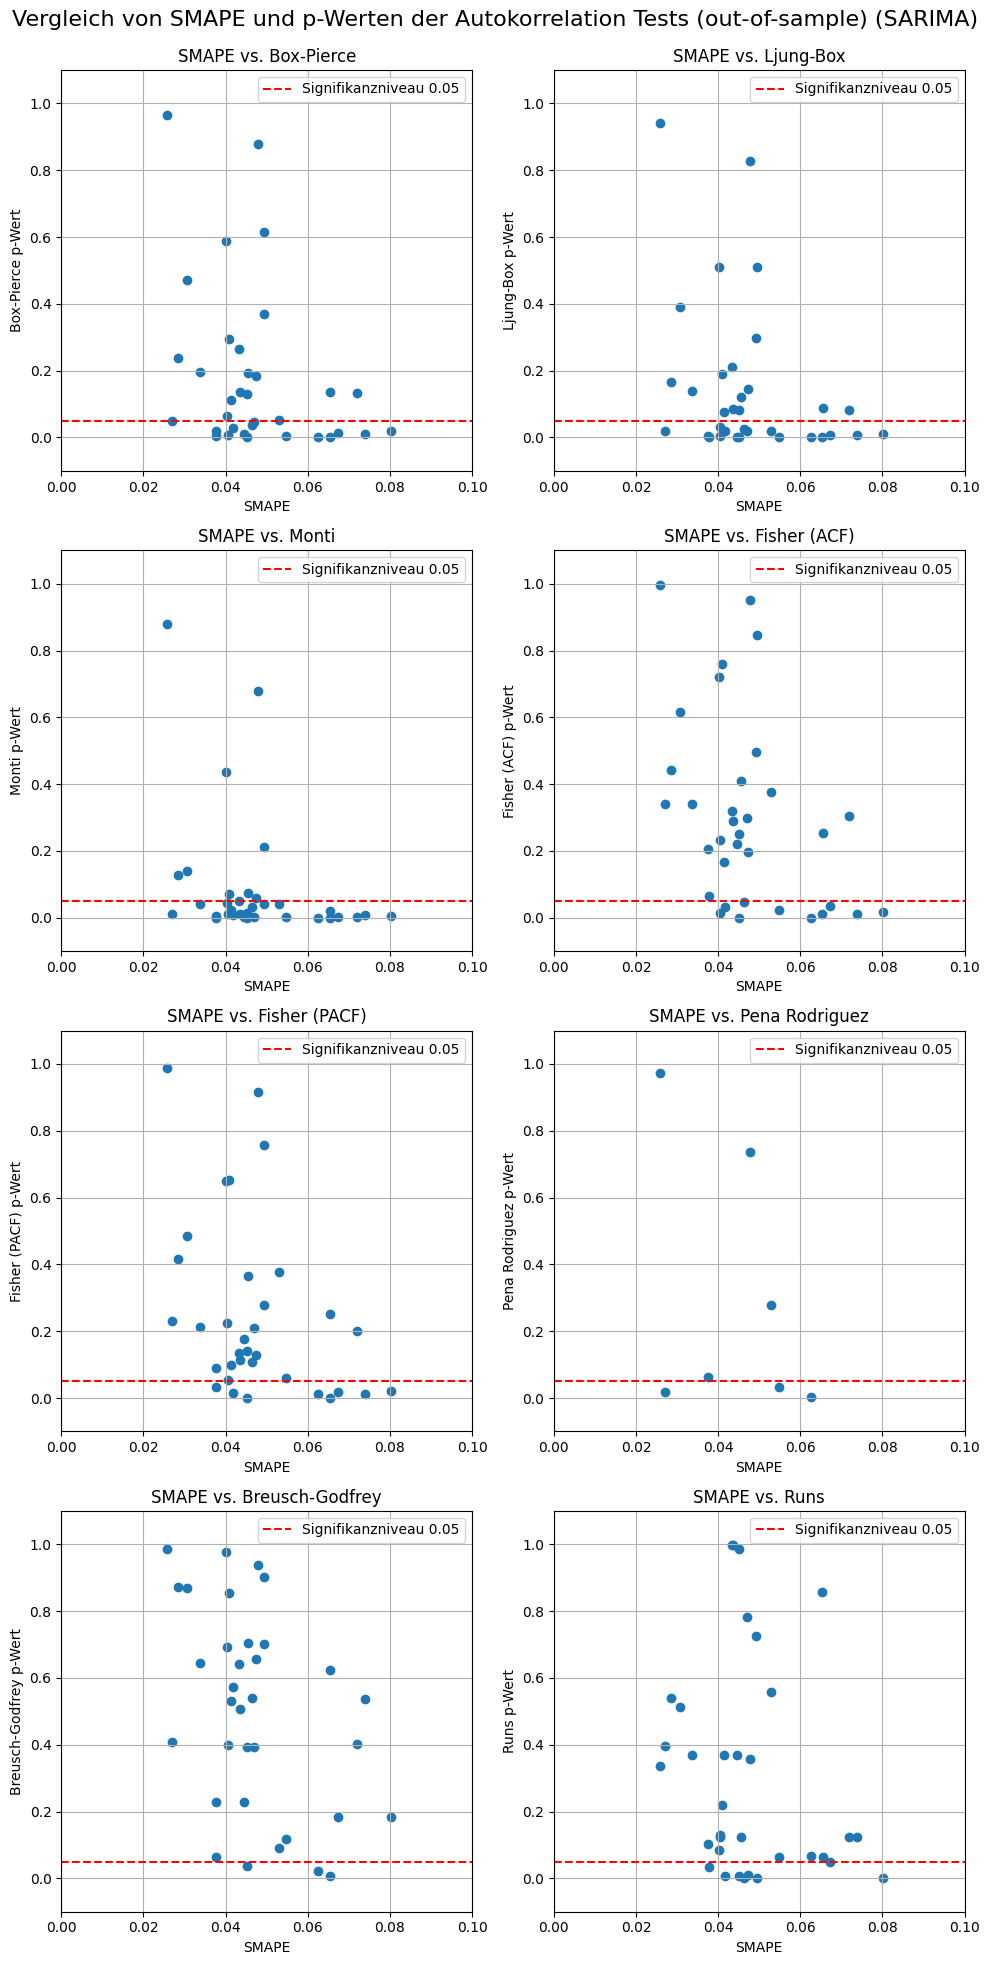

[[0.1298954854064516, 0.47072469471842515, 0.011014981377527986, 0.9652816743153351, 0.014763950700460516, 0.027324868126016023, 8.815354333678218e-07, 0.19681750532492662, 3.432083476704848e-30, 0.18344560804163323, 0.2655901231455264, 4.439001806423517e-05, 0.5873106854516454, 1.445892075409687e-15, 0.13275938425829048, 0.006809587808730914, 9.024826216976055e-09, 0.13554318068922824, 0.04647006738857488, 0.11127892864457847, 0.0178713426873991, 0.2945767953453866, 0.37071628746355045, 0.192497025056159, 0.0033047649480025085, 0.06484204217722693, 0.13638215704828616, 8.179922879881135e-05, 0.6162804781324555, 9.654830238844299e-11, 9.297486321354691e-30, 0.2385389940549138, 8.487105645213079e-10, 0.05048524116909507, 9.014963446216761e-11, 1.976410887771634e-11, 0.8776256033056279, 0.052294693586205636, 5.744933970860087e-26, 0.009247715567729792, 3.7638844341373226e-27, 0.020228387715712715, 0.004227155474938548, 0.0025908536562801094, 0.0380543012782857], [0.08162350653889927, 0.3

In [20]:
fig, axes = plt.subplots(4, 2, figsize=(10, 20))

smape_dec = np.asarray(smape_stats) / 100
p_values_list = [bp_pvalues, lb_pvalues, m_pvalues, f_pvalues, f2_pvalues, pr_pvalues, bg_pvalues, rt_pvalues]
test_names = ["Box-Pierce", "Ljung-Box", "Monti", "Fisher (ACF)", "Fisher (PACF)", "Pena Rodriguez", "Breusch-Godfrey", "Runs"]

for i, ax in enumerate(axes.flat):
    ax.scatter(smape_dec, p_values_list[i])
    ax.set_xlabel('SMAPE')
    ax.set_ylabel(f'{test_names[i]} p-Wert')
    ax.set_title(f'SMAPE vs. {test_names[i]}')
    ax.grid(True)
    ax.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
    ax.legend()
    ax.set_xlim(0, 0.1)
    ax.set_ylim(-0.1, 1.1)


fig.suptitle('Vergleich von SMAPE und p-Werten der Autokorrelation Tests (out-of-sample) ({})'.format(model_type), fontsize=16)
plt.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

print(p_values_list)

SMAPE vs. Mittelwert p-Werte

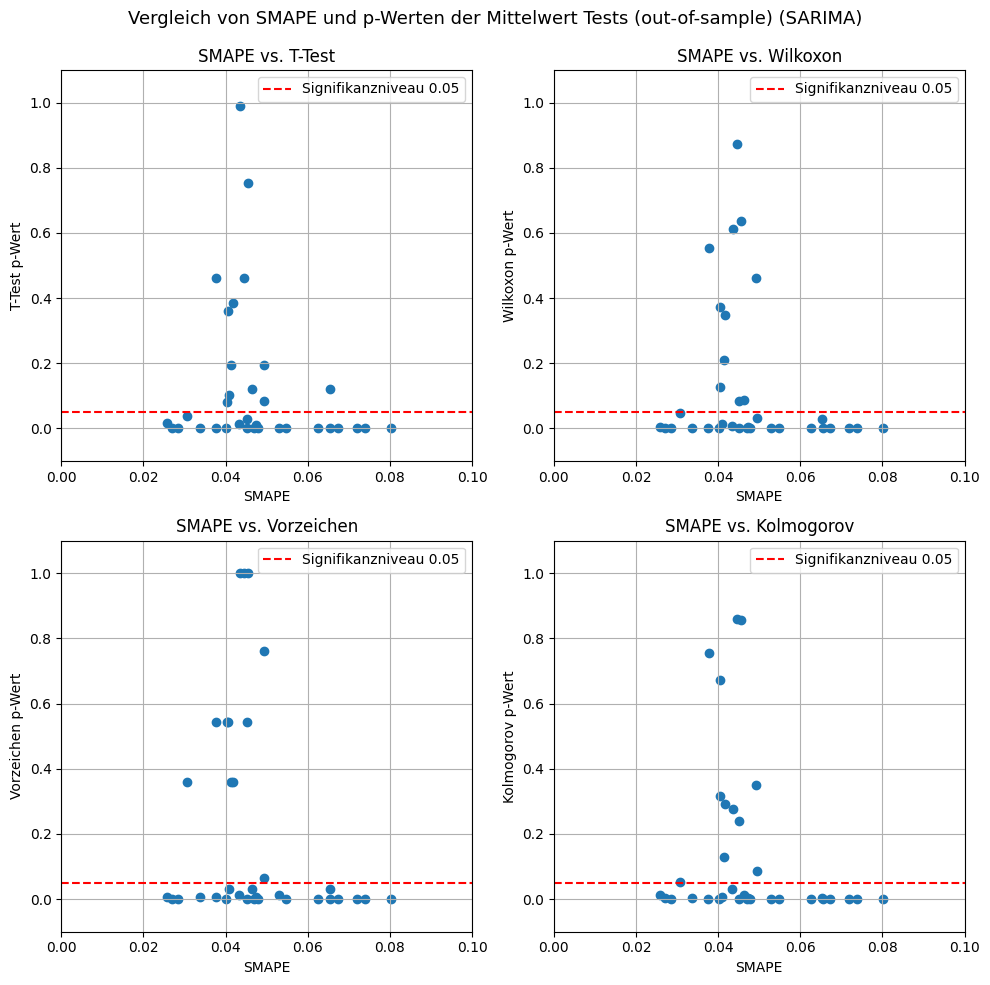

[[1.1797413318415176e-05, 0.03720734539388571, 8.274384994088026e-08, 0.01703217525065845, 1.943568565978666e-09, 0.3853372478308055, 8.242769475144373e-07, 0.0023159758866714663, 7.76454264519205e-20, 0.010577040572257099, 0.012240896768687583, 0.03023525664092957, 2.3058924899481613e-05, 8.72762668101405e-11, 7.244069545157499e-07, 0.36004506552533877, 6.881590405886733e-16, 0.9899961640450168, 0.00016608630382308677, 0.19541837483082225, 3.640473909542753e-13, 0.10158553337534117, 0.19602665831885574, 0.7534155603389965, 0.4613962329003457, 0.07965058878406739, 6.217944125936146e-08, 0.12160343296064782, 0.08273046833247424, 1.703482068800772e-30, 7.463247170648598e-20, 0.0012672608712784542, 4.155139079862412e-24, 0.000927134120719483, 3.3398329708881553e-20, 9.002231954746346e-25, 2.5155705846850114e-11, 0.0001640973266704468, 3.2734820122752576e-21, 0.46215690699406675, 4.954100269760565e-23, 0.0027759741889772788, 2.3065272066836026e-09, 7.323578720503635e-26, 0.1220406367311608

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

smape_dec = np.asarray(smape_stats) / 100
p_values_list = [t_pvalues, w_pvalues, s_pvalues, k_pvalues]
test_names = ["T-Test", "Wilkoxon", "Vorzeichen", "Kolmogorov"]

for i, ax in enumerate(axes.flat):
    ax.scatter(smape_dec, p_values_list[i])
    ax.set_xlabel('SMAPE')
    ax.set_ylabel(f'{test_names[i]} p-Wert')
    ax.set_title(f'SMAPE vs. {test_names[i]}')
    ax.grid(True)
    ax.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
    ax.legend()
    ax.set_xlim(0, 0.1)
    ax.set_ylim(-0.1, 1.1)


fig.suptitle('Vergleich von SMAPE und p-Werten der Mittelwert Tests (out-of-sample) ({})'.format(model_type), fontsize=13)
plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

print(p_values_list)


p_values_list_new = [t_pvalues, w_pvalues, s_pvalues]
print(p_values_list_new)